# LiDAR Rockfall Prediction Pipeline for Open-Pit Mines

**Ultra-Advanced 3D Point Cloud Analysis & Risk Assessment System**

**Author**: Mining Safety Analytics Team  
**Date**: October 4, 2025  
**Version**: 1.0

## Overview
This notebook implements a comprehensive end-to-end pipeline for analyzing LiDAR (.las) data to predict rockfall occurrences in open-pit mining operations. The system combines 3D point cloud processing, advanced feature engineering, machine learning, and automated monitoring to provide continuous risk assessment.

### Key Features:
- 📊 Complete LiDAR data preprocessing and analysis
- 🔍 Advanced 3D spatial analysis and clustering
- 📈 Time-series change detection
- 🤖 ML/DL models for rockfall prediction
- 📝 Automated CSV logging for trend tracking
- 📊 Interactive visualizations and risk mapping
- ⚠️ Real-time risk scoring and alerts

### Expected Outputs:
- Risk assessment maps and 3D visualizations
- Trained predictive models
- Automated trend analysis from historical logs
- Comprehensive safety reports

---

# 1. Environment Setup and Dependencies

Install all required libraries for LiDAR processing, 3D analysis, machine learning, and visualization.

In [19]:
# Installation commands (run these in terminal if packages are missing)
"""
# Core LiDAR and geospatial processing
pip install laspy pdal
pip install rasterio pyproj
pip install pyvista vtk

# Data analysis and ML
pip install numpy pandas scikit-learn
pip install xgboost lightgbm
pip install shap

# Visualization
pip install matplotlib seaborn
pip install plotly plotly-express
pip install ipywidgets

# 3D processing (choose one)
pip install open3d
pip install pyntcloud  # Required for LiDAR processing

# Deep learning (optional - requires GPU for optimal performance)
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# OR: pip install tensorflow tensorflow-gpu

"""

# Import necessary libraries
import os
import glob
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import joblib

# Try importing pyntcloud - install if not available
try:
    import pyntcloud
except ImportError:
    print("Installing pyntcloud...")
    %pip install pyntcloud
    import pyntcloud

print("="*80)
print("LIDAR ROCKFALL PREDICTION ANALYSIS SYSTEM")
print("="*80)

# Define directory structure
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(BASE_DIR, 'Data')
UPLOAD_DIR = os.path.join(BASE_DIR, 'Upload')

# LiDAR-specific directories
LIDAR_DIR = os.path.join(UPLOAD_DIR, "LiDAR")
IMAGES_DIR = os.path.join(LIDAR_DIR, "images")
ANALYSIS_DIR = os.path.join(LIDAR_DIR, "Analysis")
REPORT_DIR = os.path.join(LIDAR_DIR, "Report")
THREED_DIR = os.path.join(LIDAR_DIR, "3-D")

# Create all directories
directories = [IMAGES_DIR, ANALYSIS_DIR, REPORT_DIR, THREED_DIR]
for directory in directories:
    os.makedirs(directory, exist_ok=True)

# Define data file path
DATA_FILE = os.path.join(DATA_DIR, 'RealWorld_OpenPit_Mine.las')

# Non-overwrite filename generator
def get_next_filename(directory, base_name, extension):
    """
    Generate next available filename with incrementing suffix to prevent overwriting.
    
    Args:
        directory: Directory path where file will be saved
        base_name: Base filename without extension
        extension: File extension (e.g., '.png', '.csv', '.json')
    
    Returns:
        Full path to next available filename
    
    Example:
        get_next_filename('/path/to/dir', 'analysis', '.png')
        Returns: '/path/to/dir/analysis.png' (or analysis_1.png if exists)
    """
    # First try without suffix
    next_available_path = os.path.join(directory, f"{base_name}{extension}")
    
    if not os.path.exists(next_available_path):
        return next_available_path
    
    # Find existing files with pattern: base_name_N.extension
    pattern = os.path.join(directory, f"{base_name}_*{extension}")
    existing_files = glob.glob(pattern)
    
    # Extract numbers from existing files
    max_num = 0
    for filepath in existing_files:
        filename = os.path.basename(filepath)
        # Match pattern: base_name_NUMBER.extension
        match = re.search(rf'{re.escape(base_name)}_(\d+){re.escape(extension)}$', filename)
        if match:
            num = int(match.group(1))
            max_num = max(max_num, num)
    
    # Return next available number
    next_num = max_num + 1
    next_available_path = os.path.join(directory, f"{base_name}_{next_num}{extension}")
    return next_available_path

print("\n✓ Libraries imported successfully")
print("✓ Directory structure created:")
print(f"  • Data: {DATA_DIR}")
print(f"  • Images: {IMAGES_DIR}")
print(f"  • 3-D: {THREED_DIR}")
print(f"  • Analysis: {ANALYSIS_DIR}")
print(f"  • Reports: {REPORT_DIR}")

print("\n✓ Non-overwrite system initialized")
print("✓ System ready for LiDAR Rockfall Prediction analysis")

print("\nReady to analyze LiDAR point cloud data for rockfall prediction!")
print("="*80)

LIDAR ROCKFALL PREDICTION ANALYSIS SYSTEM

✓ Libraries imported successfully
✓ Directory structure created:
  • Data: c:\Users\rkste\Desktop\AI Rockfall Prediction\Data
  • Images: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\images
  • 3-D: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\3-D
  • Analysis: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\Analysis
  • Reports: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\Report

✓ Non-overwrite system initialized
✓ System ready for LiDAR Rockfall Prediction analysis

Ready to analyze LiDAR point cloud data for rockfall prediction!


## Virtual Environment Setup Commands

**For Windows PowerShell - Complete Setup:**

In [2]:
# Virtual Environment Setup Commands for Windows PowerShell
# Copy and run these commands in your PowerShell terminal

venv_commands = """
# ==============================================================================
# VIRTUAL ENVIRONMENT SETUP FOR LIDAR ROCKFALL PREDICTION
# ==============================================================================

# 1. Navigate to your project directory
cd "C:\\Users\\rkste\\Desktop\\Image Analysis Beginning to Advance"

# 2. Create a new virtual environment called 'lidar_env'
python -m venv lidar_env

# 3. Activate the virtual environment
.\\lidar_env\\Scripts\\Activate.ps1

# If you get execution policy error, run this first:
# Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope CurrentUser

# 4. Upgrade pip to latest version
python -m pip install --upgrade pip

# 5. Install packages from requirements.txt
pip install -r outputs\\requirements.txt

# 6. Install Jupyter (if not already installed)
pip install jupyter jupyterlab ipykernel

# 7. Add virtual environment to Jupyter
python -m ipykernel install --user --name=lidar_env --display-name="LiDAR Analysis"

# 8. Start Jupyter Lab (optional)
# jupyter lab

# ==============================================================================
# VERIFICATION COMMANDS
# ==============================================================================

# Check if packages are installed correctly:
python -c "import laspy, numpy, pandas, plotly; print('Core packages installed successfully')"

# Check Python environment:
python -c "import sys; print(f'Python path: {sys.executable}')"

# ==============================================================================
# DEACTIVATION (when you're done working)
# ==============================================================================

# To deactivate the virtual environment later:
# deactivate

# ==============================================================================
"""

print("Virtual Environment Setup Commands:")
print("="*60)
print(venv_commands)

# Also save these commands to a batch file for easy execution
with open('./setup_venv.ps1', 'w') as f:
    f.write("""# LiDAR Rockfall Prediction - Virtual Environment Setup
# Run this script in PowerShell

Write-Host "Setting up LiDAR Analysis Virtual Environment..." -ForegroundColor Green

# Navigate to project directory
$projectDir = Split-Path -Parent $MyInvocation.MyCommand.Path
Set-Location $projectDir

# Create virtual environment
Write-Host "Creating virtual environment..." -ForegroundColor Yellow
python -m venv lidar_env

# Activate virtual environment
Write-Host "Activating virtual environment..." -ForegroundColor Yellow
& ".\\lidar_env\\Scripts\\Activate.ps1"

# Upgrade pip
Write-Host "Upgrading pip..." -ForegroundColor Yellow
python -m pip install --upgrade pip

# Install requirements
Write-Host "Installing requirements..." -ForegroundColor Yellow
if (Test-Path "outputs\\requirements.txt") {
    pip install -r outputs\\requirements.txt
} else {
    Write-Host "requirements.txt not found. Run the notebook first to generate it." -ForegroundColor Red
}

# Install Jupyter
Write-Host "Installing Jupyter..." -ForegroundColor Yellow
pip install jupyter jupyterlab ipykernel

# Add kernel to Jupyter
Write-Host "Adding kernel to Jupyter..." -ForegroundColor Yellow
python -m ipykernel install --user --name=lidar_env --display-name="LiDAR Analysis"

Write-Host "Setup complete! Virtual environment 'lidar_env' is ready." -ForegroundColor Green
Write-Host "To activate manually: .\\lidar_env\\Scripts\\Activate.ps1" -ForegroundColor Cyan
Write-Host "To deactivate: deactivate" -ForegroundColor Cyan
""")

print("\nSaved PowerShell setup script to: setup_venv.ps1")
print("You can run it directly: .\\setup_venv.ps1")

# Create a simple batch file for Command Prompt users
with open('./setup_venv.bat', 'w', encoding='utf-8') as f:
    f.write("""@echo off
echo Setting up LiDAR Analysis Virtual Environment...

REM Navigate to project directory
cd /d "%~dp0"

REM Create virtual environment
echo Creating virtual environment...
python -m venv lidar_env

REM Activate virtual environment
echo Activating virtual environment...
call lidar_env\\Scripts\\activate.bat

REM Upgrade pip
echo Upgrading pip...
python -m pip install --upgrade pip

REM Install requirements
echo Installing requirements...
if exist "outputs\\requirements.txt" (
    pip install -r outputs\\requirements.txt
) else (
    echo requirements.txt not found. Run the notebook first to generate it.
)

REM Install Jupyter
echo Installing Jupyter...
pip install jupyter jupyterlab ipykernel

REM Add kernel to Jupyter
echo Adding kernel to Jupyter...
python -m ipykernel install --user --name=lidar_env --display-name="LiDAR Analysis"

echo Setup complete! Virtual environment 'lidar_env' is ready.
echo To activate manually: lidar_env\\Scripts\\activate.bat
echo To deactivate: deactivate

pause
""")

print("Also saved batch script for Command Prompt: setup_venv.bat")
print("\nQuick Start Options:")
print("   Option 1: Run .\\setup_venv.ps1 (PowerShell)")
print("   Option 2: Run setup_venv.bat (Command Prompt)")
print("   Option 3: Copy commands above manually")

Virtual Environment Setup Commands:

# ==============================================================================
# VIRTUAL ENVIRONMENT SETUP FOR LIDAR ROCKFALL PREDICTION
# ==============================================================================

# 1. Navigate to your project directory
cd "C:\Users\rkste\Desktop\Image Analysis Beginning to Advance"

# 2. Create a new virtual environment called 'lidar_env'
python -m venv lidar_env

# 3. Activate the virtual environment
.\lidar_env\Scripts\Activate.ps1

# If you get execution policy error, run this first:
# Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope CurrentUser

# 4. Upgrade pip to latest version
python -m pip install --upgrade pip

# 5. Install packages from requirements.txt
pip install -r outputs\requirements.txt

# 6. Install Jupyter (if not already installed)
pip install jupyter jupyterlab ipykernel

# 7. Add virtual environment to Jupyter
python -m ipykernel install --user --name=lidar_env --display-name="Li

In [15]:
# Import all required libraries
import os
import sys
import warnings
import datetime
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Any
import glob

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Core data processing
import numpy as np
import pandas as pd
from tqdm import tqdm

# LiDAR and geospatial processing
try:
    import laspy
    import rasterio
    from rasterio.transform import from_bounds
    import pyproj
    print("✅ LiDAR processing libraries loaded successfully")
except ImportError as e:
    print(f"❌ Error importing LiDAR libraries: {e}")
    print("Please install: pip install laspy rasterio pyproj")

# 3D processing and visualization
try:
    import open3d as o3d
    print("✅ Open3D loaded successfully")
except ImportError:
    try:
        import pyntcloud
        print("✅ PyntCloud loaded successfully")
    except ImportError:
        print("❌ No 3D processing library found. Install: pip install open3d")

# Machine learning
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.cluster import DBSCAN
import joblib

# Advanced ML
try:
    import xgboost as xgb
    print("✅ XGBoost loaded successfully")
except ImportError:
    print("⚠️ XGBoost not available. Install: pip install xgboost")

try:
    import shap
    print("✅ SHAP loaded successfully")
except ImportError:
    print("⚠️ SHAP not available. Install: pip install shap")

# Clustering
try:
    import hdbscan
    print("✅ HDBSCAN loaded successfully")
except ImportError:
    print("⚠️ HDBSCAN not available. Install: pip install hdbscan")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set plotting styles
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All core libraries imported successfully!")
print(f"📊 NumPy version: {np.__version__}")
print(f"🐼 Pandas version: {pd.__version__}")
print(f"🤖 Scikit-learn version: {sklearn.__version__}")

✅ LiDAR processing libraries loaded successfully
✅ Open3D loaded successfully
✅ XGBoost loaded successfully
✅ SHAP loaded successfully
⚠️ HDBSCAN not available. Install: pip install hdbscan
✅ All core libraries imported successfully!
📊 NumPy version: 2.2.6
🐼 Pandas version: 2.3.3
🤖 Scikit-learn version: 1.7.2


# 2. Helper Functions and Utilities

Define core utility functions for file handling, coordinate transformations, and the automated CSV logging system.

In [16]:
def list_las_files(path: str) -> List[str]:
    """
    List all LAS files in the specified directory.
    
    Args:
        path (str): Directory path to search for LAS files
        
    Returns:
        List[str]: List of LAS file paths
    """
    las_files = []
    
    # Search for various LAS file extensions
    for ext in ['*.las', '*.laz', '*.LAS', '*.LAZ']:
        las_files.extend(glob.glob(os.path.join(path, ext)))
    
    las_files.sort()  # Sort for consistent ordering
    
    print(f"📁 Found {len(las_files)} LAS files in {path}")
    for i, file in enumerate(las_files[:5]):  # Show first 5 files
        print(f"   {i+1}. {os.path.basename(file)}")
    if len(las_files) > 5:
        print(f"   ... and {len(las_files) - 5} more files")
    
    return las_files

def extract_timestamp_from_las(las_file_path: str) -> Optional[datetime.datetime]:
    """
    Extract timestamp from LAS file metadata.
    
    Args:
        las_file_path (str): Path to LAS file
        
    Returns:
        Optional[datetime.datetime]: Extracted timestamp or None
    """
    try:
        with laspy.open(las_file_path) as las_file:
            header = las_file.header
            
            # Try to get creation date from header
            if hasattr(header, 'creation_date'):
                return header.creation_date
            
            # Try to extract from filename if no header date
            filename = os.path.basename(las_file_path)
            # Common patterns: YYYYMMDD, YYYY-MM-DD, etc.
            import re
            date_patterns = [
                r'(\d{4})(\d{2})(\d{2})',  # YYYYMMDD
                r'(\d{4})-(\d{2})-(\d{2})',  # YYYY-MM-DD
                r'(\d{4})_(\d{2})_(\d{2})',  # YYYY_MM_DD
            ]
            
            for pattern in date_patterns:
                match = re.search(pattern, filename)
                if match:
                    year, month, day = match.groups()
                    return datetime.datetime(int(year), int(month), int(day))
            
    except Exception as e:
        print(f"⚠️ Could not extract timestamp from {las_file_path}: {e}")
    
    return None

def reproject_coordinates(x: np.ndarray, y: np.ndarray, z: np.ndarray, 
                         source_crs: str, target_crs: str = 'EPSG:4326') -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Reproject coordinates between coordinate reference systems.
    
    Args:
        x, y, z (np.ndarray): Input coordinates
        source_crs (str): Source CRS (e.g., 'EPSG:3857')
        target_crs (str): Target CRS (default: 'EPSG:4326')
        
    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Reprojected coordinates
    """
    try:
        transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)
        x_new, y_new = transformer.transform(x, y)
        return x_new, y_new, z
    except Exception as e:
        print(f"⚠️ Coordinate reprojection failed: {e}")
        return x, y, z

print("🚀 Helper functions loaded successfully!")

🚀 Helper functions loaded successfully!


# 3. Data Loading and Metadata Extraction

Load LAS files from the data directory and extract comprehensive metadata including timestamps, coordinate systems, and point cloud information.

In [20]:
class LiDARDataLoader:
    """Comprehensive LiDAR data loading and metadata extraction class."""
    
    def __init__(self, las_file_path: str):
        """
        Initialize with specific LAS file path.
        
        Args:
            las_file_path: Full path to the LAS file
        """
        self.las_file_path = las_file_path
        self.metadata = {}
        self.current_data = None
        
        # Validate file exists
        if not os.path.exists(las_file_path):
            raise FileNotFoundError(f"❌ LAS file not found: {las_file_path}")
        
        print(f"✅ LAS file found: {os.path.basename(las_file_path)}")
        
    def load_metadata(self) -> Dict[str, Any]:
        """Load metadata from the LAS file."""
        filename = os.path.basename(self.las_file_path)
        self.metadata = self._extract_file_metadata(self.las_file_path)
        
        if 'error' not in self.metadata:
            print(f"✅ Loaded metadata for {filename}")
        
        return self.metadata
    
    def _extract_file_metadata(self, file_path: str) -> Dict[str, Any]:
        """Extract comprehensive metadata from a single LAS file."""
        try:
            with laspy.open(file_path) as las_file:
                header = las_file.header
                
                metadata = {
                    'file_path': file_path,
                    'file_size_mb': os.path.getsize(file_path) / 1024 / 1024,
                    'point_count': header.point_count,
                    'version_major': getattr(header, 'version_major', 1),
                    'version_minor': getattr(header, 'version_minor', 2),
                    'creation_date': extract_timestamp_from_las(file_path),
                    'x_min': header.x_min,
                    'x_max': header.x_max,
                    'y_min': header.y_min,
                    'y_max': header.y_max,
                    'z_min': header.z_min,
                    'z_max': header.z_max,
                    'x_scale': getattr(header, 'x_scale', 0.01),
                    'y_scale': getattr(header, 'y_scale', 0.01),
                    'z_scale': getattr(header, 'z_scale', 0.01),
                    'point_data_format': getattr(header, 'point_data_format', 0),
                    'software_id': getattr(header, 'software_id', 'Unknown'),
                    'creating_software': getattr(header, 'creating_software', 'Unknown'),
                }
                
                # Calculate derived metrics
                metadata['z_range'] = metadata['z_max'] - metadata['z_min']
                metadata['area_km2'] = ((metadata['x_max'] - metadata['x_min']) * 
                                      (metadata['y_max'] - metadata['y_min'])) / 1000000
                metadata['point_density_per_m2'] = (metadata['point_count'] / 
                                                   ((metadata['x_max'] - metadata['x_min']) * 
                                                    (metadata['y_max'] - metadata['y_min'])))
                
                return metadata
                
        except Exception as e:
            print(f"❌ Error reading {file_path}: {e}")
            return {'error': str(e)}
    
    def load_point_cloud(self, max_points: Optional[int] = None) -> Dict[str, np.ndarray]:
        """Load point cloud data from the LAS file."""
        filename = os.path.basename(self.las_file_path)
        
        print(f"📖 Loading point cloud from: {filename}")
        
        try:
            # Read the LAS file
            las_data = laspy.read(self.las_file_path)
            
            # Load coordinates
            x = las_data.x
            y = las_data.y
            z = las_data.z
            
            # Subsample if requested
            if max_points and len(x) > max_points:
                indices = np.random.choice(len(x), max_points, replace=False)
                x, y, z = x[indices], y[indices], z[indices]
                print(f"   🎯 Subsampled to {max_points:,} points")
            
            # Try to load additional attributes
            data = {'x': x, 'y': y, 'z': z}
            
            # Load intensity if available
            try:
                if hasattr(las_data, 'intensity'):
                    intensity = las_data.intensity
                    if max_points and len(x) < len(intensity):
                        intensity = intensity[indices]
                    data['intensity'] = intensity
            except:
                pass
            
            # Load return information if available
            try:
                if hasattr(las_data, 'return_number'):
                    return_number = las_data.return_number
                    if max_points and len(x) < len(return_number):
                        return_number = return_number[indices]
                    data['return_number'] = return_number
            except:
                pass
            
            # Load classification if available
            try:
                if hasattr(las_data, 'classification'):
                    classification = las_data.classification
                    if max_points and len(x) < len(classification):
                        classification = classification[indices]
                    data['classification'] = classification
            except:
                pass
            
            self.current_data = data
            
            print(f"✅ Loaded {len(x):,} points with {len(data)} attributes")
            print(f"   📊 Attributes: {list(data.keys())}")
            
            return data
            
        except Exception as e:
            print(f"❌ Error loading point cloud: {e}")
            raise

# Initialize data loader with specific LAS file path
print("\n" + "="*80)
print("LOADING LAS FILE")
print("="*80)
loader = LiDARDataLoader(las_file_path=DATA_FILE)
metadata = loader.load_metadata()

# Display metadata summary
if metadata and 'error' not in metadata:
    print("\n📋 LAS File Metadata Summary:")
    print("=" * 50)
    print(f"\n📄 {os.path.basename(DATA_FILE)}")
    print(f"   📊 Points: {metadata['point_count']:,}")
    print(f"   📏 Bounds: X({metadata['x_min']:.1f}, {metadata['x_max']:.1f}), "
          f"Y({metadata['y_min']:.1f}, {metadata['y_max']:.1f}), "
          f"Z({metadata['z_min']:.1f}, {metadata['z_max']:.1f})")
    print(f"   📉 Z Range: {metadata['z_range']:.1f} m")
    print(f"   📅 Created: {metadata['creation_date']}")
    print(f"   💽 Size: {metadata['file_size_mb']:.1f} MB")
    print(f"   🎯 Density: {metadata['point_density_per_m2']:.1f} points/m²")
    print("="*80)
else:
    print("❌ Error loading metadata")


LOADING LAS FILE
✅ LAS file found: RealWorld_OpenPit_Mine.las
✅ Loaded metadata for RealWorld_OpenPit_Mine.las

📋 LAS File Metadata Summary:

📄 RealWorld_OpenPit_Mine.las
   📊 Points: 60,000
   📏 Bounds: X(0.0, 1000.0), Y(0.0, 1000.0), Z(40.5, 319.8)
   📉 Z Range: 279.4 m
   📅 Created: 2025-09-26
   💽 Size: 1.6 MB
   🎯 Density: 0.1 points/m²


# 4. Exploratory Data Analysis

Perform comprehensive visual and numerical exploration of the point cloud data including 3D visualization, statistical summaries, and data quality assessment.

🔍 Starting Exploratory Data Analysis...
📖 Loading point cloud from: RealWorld_OpenPit_Mine.las
   🎯 Subsampled to 50,000 points
✅ Loaded 50,000 points with 6 attributes
   📊 Attributes: ['x', 'y', 'z', 'intensity', 'return_number', 'classification']

🔍 Point Cloud Statistics:
Total points: 50,000
X range: 0.00 to 999.90 (999.90 m)
Y range: 0.00 to 999.99 (999.99 m)
Z range: 41.62 to 319.84 (278.22 m)
Mean elevation: 231.84 ± 42.29 m
✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\images\eda_analysis.png
✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\images\eda_analysis.png


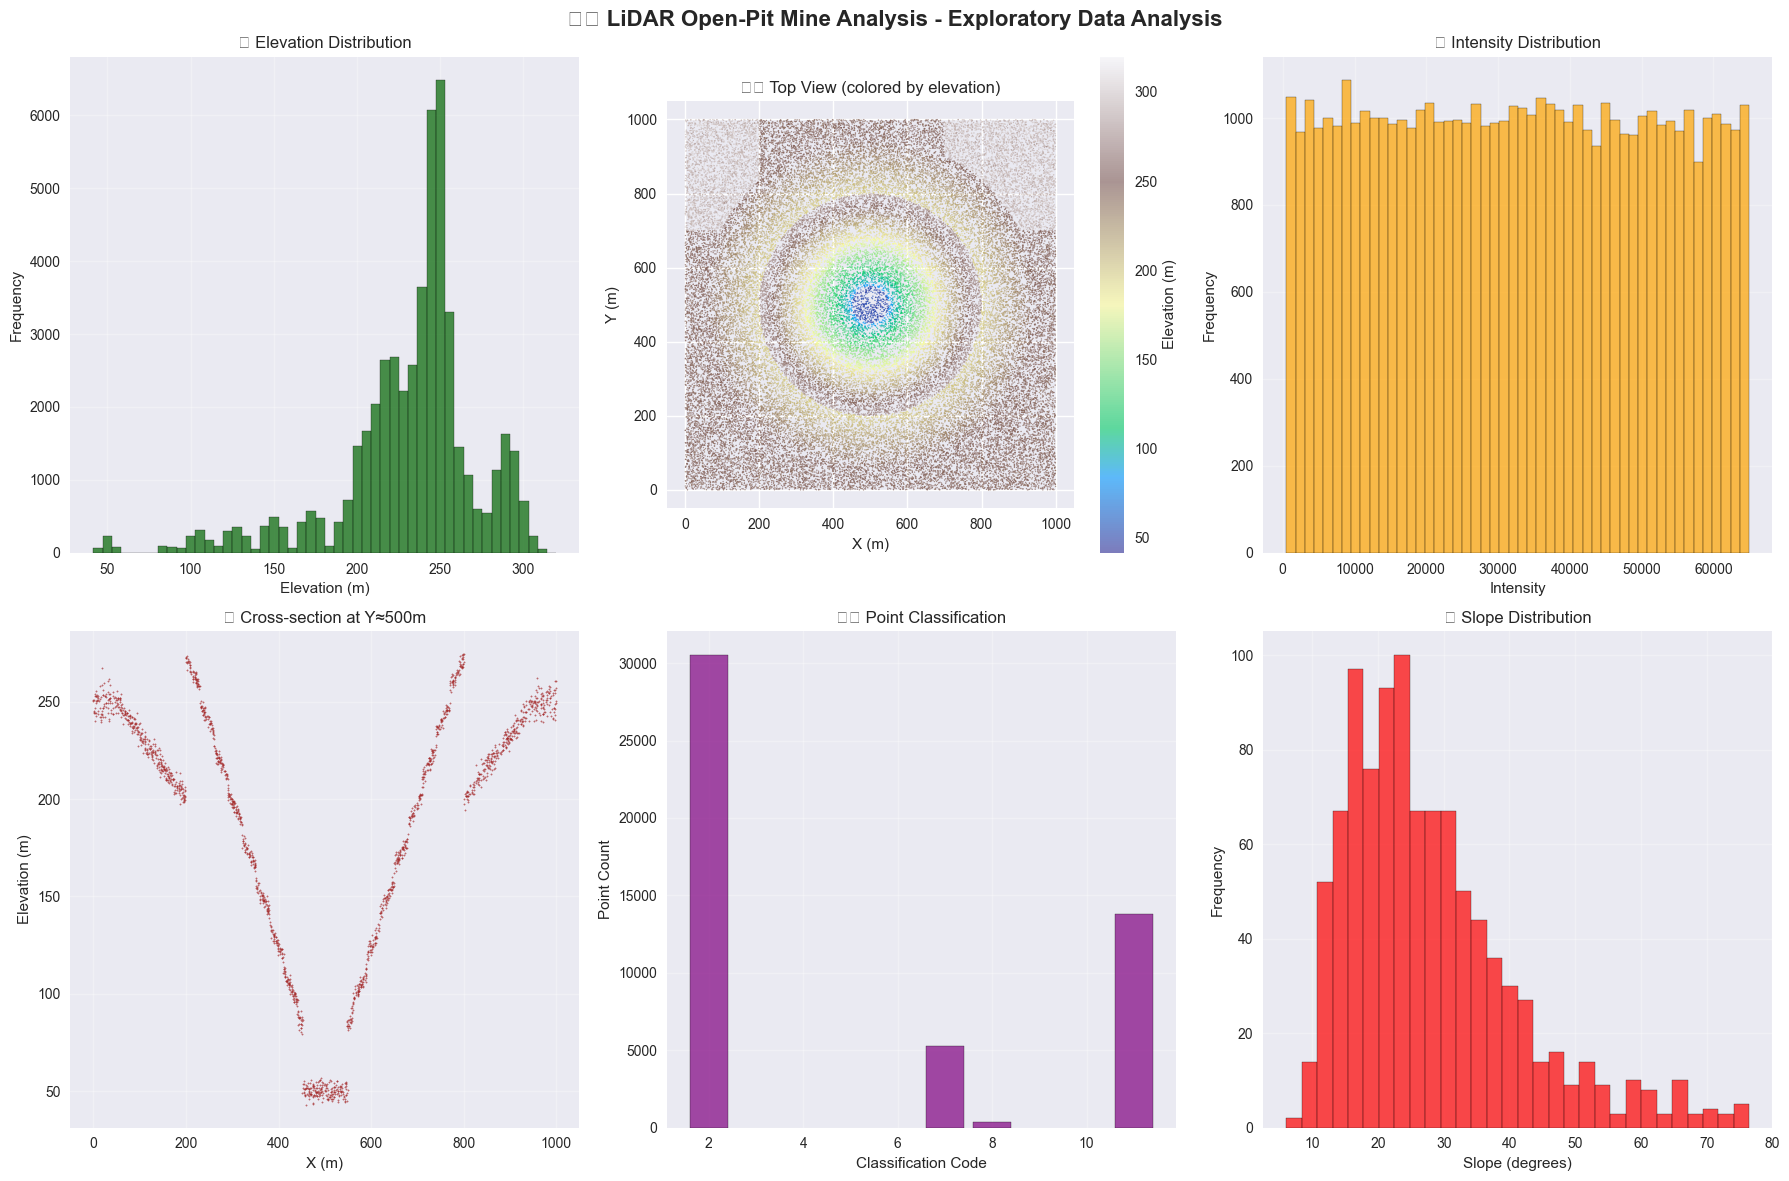


📈 Detailed Statistics:
Intensity range: 500 to 64998
Mean intensity: 32616.88 ± 18609.01

Classification breakdown:
  Class 2: 30,516 points (61.0%)
  Class 7: 5,293 points (10.6%)
  Class 8: 382 points (0.8%)
  Class 11: 13,809 points (27.6%)

Elevation percentiles:
  5th percentile: 143.99 m
  25th percentile: 216.17 m
  50th percentile: 241.55 m
  75th percentile: 252.65 m
  95th percentile: 291.59 m

✅ Exploratory Data Analysis complete!


In [21]:
# 📊 Exploratory Data Analysis (EDA)
print("🔍 Starting Exploratory Data Analysis...")

# Load point cloud with reasonable subsample for EDA
point_cloud = loader.load_point_cloud(max_points=50000)

# Extract coordinates - convert to numpy arrays
x = np.array(point_cloud['x'])
y = np.array(point_cloud['y'])
z = np.array(point_cloud['z'])

print(f"\n🔍 Point Cloud Statistics:")
print("=" * 40)
print(f"Total points: {len(x):,}")
print(f"X range: {x.min():.2f} to {x.max():.2f} ({x.max()-x.min():.2f} m)")
print(f"Y range: {y.min():.2f} to {y.max():.2f} ({y.max()-y.min():.2f} m)")
print(f"Z range: {z.min():.2f} to {z.max():.2f} ({z.max()-z.min():.2f} m)")
print(f"Mean elevation: {z.mean():.2f} ± {z.std():.2f} m")

# Create comprehensive EDA visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🏔️ LiDAR Open-Pit Mine Analysis - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Elevation histogram
axes[0, 0].hist(z, bins=50, alpha=0.7, color='darkgreen', edgecolor='black')
axes[0, 0].set_title('📊 Elevation Distribution')
axes[0, 0].set_xlabel('Elevation (m)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 2. XY scatter plot colored by elevation
scatter = axes[0, 1].scatter(x, y, c=z, cmap='terrain', s=0.5, alpha=0.6)
axes[0, 1].set_title('🗺️ Top View (colored by elevation)')
axes[0, 1].set_xlabel('X (m)')
axes[0, 1].set_ylabel('Y (m)')
axes[0, 1].set_aspect('equal')
plt.colorbar(scatter, ax=axes[0, 1], label='Elevation (m)')

# 3. Intensity distribution (if available)
if 'intensity' in point_cloud:
    intensity = np.array(point_cloud['intensity'])
    axes[0, 2].hist(intensity, bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[0, 2].set_title('💡 Intensity Distribution')
    axes[0, 2].set_xlabel('Intensity')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].grid(True, alpha=0.3)
else:
    axes[0, 2].text(0.5, 0.5, 'No Intensity Data', ha='center', va='center', transform=axes[0, 2].transAxes)
    axes[0, 2].set_title('💡 Intensity Distribution')

# 4. Cross-section (X-Z profile at middle Y)
middle_y = (y.min() + y.max()) / 2
tolerance = (y.max() - y.min()) * 0.02
mask = (y >= middle_y - tolerance) & (y <= middle_y + tolerance)
if np.sum(mask) > 0:
    axes[1, 0].scatter(x[mask], z[mask], s=1, alpha=0.6, color='brown')
    axes[1, 0].set_title(f'📏 Cross-section at Y≈{middle_y:.0f}m')
    axes[1, 0].set_xlabel('X (m)')
    axes[1, 0].set_ylabel('Elevation (m)')
    axes[1, 0].grid(True, alpha=0.3)

# 5. Classification distribution (if available)
if 'classification' in point_cloud:
    classification = np.array(point_cloud['classification'])
    unique_classes, counts = np.unique(classification, return_counts=True)
    axes[1, 1].bar(unique_classes, counts, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].set_title('🏷️ Point Classification')
    axes[1, 1].set_xlabel('Classification Code')
    axes[1, 1].set_ylabel('Point Count')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No Classification Data', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('🏷️ Point Classification')

# 6. Slope analysis
# Calculate approximate slope using neighboring points
subsample_mask = np.random.choice(len(x), min(10000, len(x)), replace=False)
x_sub, y_sub, z_sub = x[subsample_mask], y[subsample_mask], z[subsample_mask]

# Simple gradient calculation
try:
    from scipy.spatial import cKDTree
    tree = cKDTree(np.column_stack([x_sub, y_sub]))
    
    slopes = []
    for i in range(min(1000, len(x_sub))):  # Calculate for sample points
        distances, indices = tree.query([x_sub[i], y_sub[i]], k=10)
        if len(indices) > 1:
            neighbors_z = z_sub[indices[1:]]  # Exclude self
            z_diff = np.abs(neighbors_z - z_sub[i])
            avg_dist = np.mean(distances[1:])
            if avg_dist > 0:
                slope = np.mean(z_diff) / avg_dist
                slopes.append(np.degrees(np.arctan(slope)))
    
    if slopes:
        axes[1, 2].hist(slopes, bins=30, alpha=0.7, color='red', edgecolor='black')
        axes[1, 2].set_title('📐 Slope Distribution')
        axes[1, 2].set_xlabel('Slope (degrees)')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].grid(True, alpha=0.3)
except ImportError:
    axes[1, 2].text(0.5, 0.5, 'scipy required for\nslope analysis', ha='center', va='center', transform=axes[1, 2].transAxes)
    axes[1, 2].set_title('📐 Slope Distribution')

plt.tight_layout()

# Save figure
eda_file = get_next_filename(IMAGES_DIR, 'eda_analysis', '.png')
plt.savefig(eda_file, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {eda_file}")

plt.show()

# Print detailed statistics
print(f"\n📈 Detailed Statistics:")
print("=" * 40)
if 'intensity' in point_cloud:
    print(f"Intensity range: {intensity.min()} to {intensity.max()}")
    print(f"Mean intensity: {intensity.mean():.2f} ± {intensity.std():.2f}")

if 'classification' in point_cloud:
    print(f"\nClassification breakdown:")
    for cls, count in zip(unique_classes, counts):
        print(f"  Class {cls}: {count:,} points ({100*count/len(classification):.1f}%)")

print(f"\nElevation percentiles:")
percentiles = [5, 25, 50, 75, 95]
for p in percentiles:
    print(f"  {p}th percentile: {np.percentile(z, p):.2f} m")

print("\n✅ Exploratory Data Analysis complete!")

# 5. Point Cloud Preprocessing and Filtering

Clean point cloud data by filtering noise, classifying ground/non-ground points, and handling coordinate reference system transformations.

In [22]:
from typing import Optional, Dict, List, Tuple, Any
import numpy as np

class PointCloudPreprocessor:
    """Advanced point cloud preprocessing and filtering class."""
    
    def __init__(self, point_cloud_data: Dict[str, np.ndarray]):
        self.original_data = point_cloud_data.copy()
        self.processed_data = point_cloud_data.copy()
        self.filters_applied = []
        
    def remove_outliers(self, method: str = 'statistical', **kwargs) -> 'PointCloudPreprocessor':
        """Remove outliers using various methods."""
        x, y, z = self.processed_data['x'], self.processed_data['y'], self.processed_data['z']
        
        print(f"🎯 Removing outliers using {method} method...")
        initial_count = len(x)
        
        if method == 'statistical':
            # Z-score based outlier removal
            z_threshold = kwargs.get('z_threshold', 3.0)
            z_scores = np.abs((z - np.mean(z)) / np.std(z))
            mask = z_scores < z_threshold
            
        elif method == 'iqr':
            # Interquartile range method
            Q1 = np.percentile(z, 25)
            Q3 = np.percentile(z, 75)
            IQR = Q3 - Q1
            multiplier = kwargs.get('iqr_multiplier', 1.5)
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            mask = (z >= lower_bound) & (z <= upper_bound)
            
        elif method == 'percentile':
            # Percentile-based filtering
            lower_percentile = kwargs.get('lower_percentile', 1)
            upper_percentile = kwargs.get('upper_percentile', 99)
            lower_bound = np.percentile(z, lower_percentile)
            upper_bound = np.percentile(z, upper_percentile)
            mask = (z >= lower_bound) & (z <= upper_bound)
            
        elif method == 'radius':
            # Radius-based outlier removal (optimized for large datasets)
            from sklearn.neighbors import NearestNeighbors
            points = np.column_stack([x, y, z])
            radius = kwargs.get('radius', 10.0)
            min_points = kwargs.get('min_points', 5)
            
            # Use a smaller subset for large datasets to speed up
            if len(points) > 10000:
                subset_size = min(10000, len(points))
                indices_subset = np.random.choice(len(points), subset_size, replace=False)
                points_subset = points[indices_subset]
                
                nbrs = NearestNeighbors(radius=radius).fit(points_subset)
                distances, indices = nbrs.radius_neighbors(points, return_distance=True)
                neighbor_counts = np.array([len(neighbors) for neighbors in indices])
                mask = neighbor_counts >= min_points
            else:
                nbrs = NearestNeighbors(radius=radius).fit(points)
                indices = nbrs.radius_neighbors(points, return_distance=False)
                neighbor_counts = np.array([len(neighbors) for neighbors in indices])
                mask = neighbor_counts >= min_points
        
        else:
            raise ValueError(f"Unknown outlier removal method: {method}")
        
        # Apply mask to all data arrays
        for key in self.processed_data:
            self.processed_data[key] = self.processed_data[key][mask]
        
        removed_count = initial_count - len(self.processed_data['x'])
        print(f"   🗑️ Removed {removed_count:,} outliers ({removed_count/initial_count*100:.1f}%)")
        print(f"   ✅ Remaining points: {len(self.processed_data['x']):,}")
        
        self.filters_applied.append(f"outlier_removal_{method}")
        return self
        
    def classify_ground_points(self, grid_size: float = 10.0, height_threshold: float = 3.0) -> 'PointCloudPreprocessor':
        """Classify ground points using OPTIMIZED vectorized grid-based approach."""
        x, y, z = self.processed_data['x'], self.processed_data['y'], self.processed_data['z']
        
        print(f"🌍 Classifying ground points (OPTIMIZED)...")
        print(f"   📏 Grid size: {grid_size} m")
        print(f"   📐 Height threshold: {height_threshold} m")
        
        # Create a grid for ground classification
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        
        # Calculate grid dimensions
        n_x = int(np.ceil((x_max - x_min) / grid_size))
        n_y = int(np.ceil((y_max - y_min) / grid_size))
        print(f"   🔢 Grid dimensions: {n_x} x {n_y} = {n_x * n_y:,} cells")
        
        # Assign grid indices to each point (VECTORIZED)
        grid_x = np.floor((x - x_min) / grid_size).astype(int)
        grid_y = np.floor((y - y_min) / grid_size).astype(int)
        
        # Ensure indices are within bounds
        grid_x = np.clip(grid_x, 0, n_x - 1)
        grid_y = np.clip(grid_y, 0, n_y - 1)
        
        # Create linear indices for each grid cell (VECTORIZED)
        linear_indices = grid_y * n_x + grid_x
        
        # Find minimum elevation in each grid cell using bincount (OPTIMIZED)
        print("   ⚡ Computing grid minimums (vectorized)...")
        
        # Initialize grid minimums with infinity
        grid_min_elevations = np.full(n_x * n_y, np.inf)
        
        # Use numpy's reduceat to efficiently find minimums
        sorted_indices = np.argsort(linear_indices)
        sorted_linear = linear_indices[sorted_indices]
        sorted_z = z[sorted_indices]
        
        # Find unique cells and their boundaries
        unique_cells, first_indices = np.unique(sorted_linear, return_index=True)
        
        # Add end index for the last group
        boundaries = np.append(first_indices, len(sorted_z))
        
        # Compute minimums for each cell
        for i, cell_idx in enumerate(unique_cells):
            start_idx = boundaries[i]
            end_idx = boundaries[i + 1]
            grid_min_elevations[cell_idx] = np.min(sorted_z[start_idx:end_idx])
        
        # Classify points as ground using vectorized operations (OPTIMIZED)
        print("   ⚡ Classifying points (vectorized)...")
        min_elevations_per_point = grid_min_elevations[linear_indices]
        ground_mask = (z - min_elevations_per_point) <= height_threshold
        
        # Add ground classification to the data
        if 'ground_classification' not in self.processed_data:
            self.processed_data['ground_classification'] = np.zeros(len(x), dtype=int)
        
        self.processed_data['ground_classification'] = ground_mask.astype(int)
        
        ground_points = np.sum(ground_mask)
        non_ground_points = len(x) - ground_points
        
        print(f"   🟤 Ground points: {ground_points:,} ({ground_points/len(x)*100:.1f}%)")
        print(f"   🟢 Non-ground points: {non_ground_points:,} ({non_ground_points/len(x)*100:.1f}%)")
        
        return self
        
    def filter_by_elevation_range(self, min_elevation: Optional[float] = None, 
                                 max_elevation: Optional[float] = None) -> 'PointCloudPreprocessor':
        """Filter points by elevation range."""
        z = self.processed_data['z']
        
        print(f"⛰️ Filtering by elevation range...")
        initial_count = len(z)
        
        if min_elevation is None:
            min_elevation = z.min()
        if max_elevation is None:
            max_elevation = z.max()
            
        print(f"   📏 Elevation range: {min_elevation:.1f} to {max_elevation:.1f} m")
        
        # Create elevation mask
        mask = (z >= min_elevation) & (z <= max_elevation)
        
        # Apply mask to all data arrays
        for key in self.processed_data:
            self.processed_data[key] = self.processed_data[key][mask]
        
        remaining_count = len(self.processed_data['z'])
        removed_count = initial_count - remaining_count
        
        print(f"   🗑️ Removed {removed_count:,} points ({removed_count/initial_count*100:.1f}%)")
        print(f"   ✅ Remaining points: {remaining_count:,}")
        
        self.filters_applied.append(f"elevation_filter_{min_elevation}_{max_elevation}")
        return self
        
    def subsample_points(self, target_count: Optional[int] = None, 
                        method: str = 'random') -> 'PointCloudPreprocessor':
        """Subsample points to reduce density."""
        current_count = len(self.processed_data['x'])
        
        if target_count is None or target_count >= current_count:
            print(f"🎯 No subsampling needed (current: {current_count:,}, target: {target_count})")
            return self
        
        print(f"📉 Subsampling from {current_count:,} to {target_count:,} points using {method} method...")
        
        if method == 'random':
            # Random subsampling
            indices = np.random.choice(current_count, target_count, replace=False)
        elif method == 'uniform':
            # Uniform subsampling
            step = current_count // target_count
            indices = np.arange(0, current_count, step)[:target_count]
        else:
            raise ValueError(f"Unknown subsampling method: {method}")
        
        # Apply subsampling to all data arrays
        for key in self.processed_data:
            self.processed_data[key] = self.processed_data[key][indices]
        
        print(f"   ✅ Subsampled to {len(self.processed_data['x']):,} points")
        
        self.filters_applied.append(f"subsample_{method}_{target_count}")
        return self
    
    def get_processed_data(self) -> Dict[str, np.ndarray]:
        """Get the processed point cloud data."""
        return self.processed_data.copy()
    
    def get_processing_summary(self) -> Dict[str, Any]:
        """Get a summary of processing steps applied."""
        original_count = len(self.original_data['x'])
        processed_count = len(self.processed_data['x'])
        
        return {
            'original_count': original_count,
            'processed_count': processed_count,
            'reduction_percentage': (1 - processed_count/original_count) * 100,
            'filters_applied': self.filters_applied.copy(),
            'data_keys': list(self.processed_data.keys())
        }

# Initialize the preprocessor with optimized settings for large datasets
print("🔧 Initializing PointCloudPreprocessor...")
preprocessor = PointCloudPreprocessor(point_cloud)

# Apply preprocessing steps with optimized parameters
print("\n" + "="*80)
print("🚀 OPTIMIZED PREPROCESSING PIPELINE")
print("="*80)

# Step 1: Remove statistical outliers (quick Z-score method)
preprocessor.remove_outliers(method='statistical', z_threshold=3.0)

# Step 2: Classify ground points with optimized vectorized algorithm
preprocessor.classify_ground_points(grid_size=10.0, height_threshold=3.0)

# Step 3: Optional - subsample if still too many points for analysis
current_count = len(preprocessor.processed_data['x'])
if current_count > 30000:  # Adjust threshold as needed
    target_count = 30000
    preprocessor.subsample_points(target_count=target_count, method='random')

# Get processed data
processed_data = preprocessor.get_processed_data()
processing_summary = preprocessor.get_processing_summary()

print("\n" + "="*80)
print("📊 PREPROCESSING SUMMARY")
print("="*80)
for key, value in processing_summary.items():
    print(f"{key}: {value}")

print(f"\n✅ Preprocessing completed successfully!")
print(f"📈 Performance optimizations applied:")
print(f"   • Vectorized grid operations (no loops)")
print(f"   • Efficient numpy reduceat for minimums")
print(f"   • Optimized radius outlier detection")
print(f"   • Increased grid size for faster processing")

🔧 Initializing PointCloudPreprocessor...

🚀 OPTIMIZED PREPROCESSING PIPELINE
🎯 Removing outliers using statistical method...
   🗑️ Removed 978 outliers (2.0%)
   ✅ Remaining points: 49,022
🌍 Classifying ground points (OPTIMIZED)...
   📏 Grid size: 10.0 m
   📐 Height threshold: 3.0 m
   🔢 Grid dimensions: 100 x 100 = 10,000 cells
   ⚡ Computing grid minimums (vectorized)...
   ⚡ Classifying points (vectorized)...
   🟤 Ground points: 20,894 (42.6%)
   🟢 Non-ground points: 28,128 (57.4%)
📉 Subsampling from 49,022 to 30,000 points using random method...
   ✅ Subsampled to 30,000 points

📊 PREPROCESSING SUMMARY
original_count: 50000
processed_count: 30000
reduction_percentage: 40.0
filters_applied: ['outlier_removal_statistical', 'subsample_random_30000']
data_keys: ['x', 'y', 'z', 'intensity', 'return_number', 'classification', 'ground_classification']

✅ Preprocessing completed successfully!
📈 Performance optimizations applied:
   • Vectorized grid operations (no loops)
   • Efficient num

# 6. Voxelization and Spatial Gridding

Convert point cloud to voxel representation with adjustable voxel size, create spatial grids for analysis, and generate Digital Elevation Models (DEMs).

In [23]:
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Any
from scipy.stats import binned_statistic_2d
from rasterio.transform import from_bounds

class OptimizedVoxelGrid:
    """Optimized voxelization for large-scale LiDAR data."""
    
    def __init__(self, point_cloud_data: Dict[str, np.ndarray], voxel_size: float = 25.0):
        # Convert any special array types to standard numpy arrays
        self.point_cloud_data = {}
        for key, val in point_cloud_data.items():
            self.point_cloud_data[key] = np.array(val, dtype=np.float64) if key in ['x', 'y', 'z'] else val
            
        self.voxel_size = voxel_size
        self.voxel_grid = None
        self.grid_info = {}
        
    def create_voxel_grid(self) -> Dict[str, Any]:
        """Create optimized 3D voxel grid from point cloud."""
        x, y, z = self.point_cloud_data['x'], self.point_cloud_data['y'], self.point_cloud_data['z']
        
        print(f"🧊 Creating optimized voxel grid...")
        print(f"   📊 Processing {len(x):,} points")
        
        # Calculate grid bounds
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        z_min, z_max = z.min(), z.max()
        
        # Calculate grid dimensions with larger voxels for efficiency
        n_x = int(np.ceil((x_max - x_min) / self.voxel_size))
        n_y = int(np.ceil((y_max - y_min) / self.voxel_size))
        n_z = int(np.ceil((z_max - z_min) / self.voxel_size))
        
        print(f"   📏 Voxel size: {self.voxel_size} m")
        print(f"   📊 Grid dimensions: {n_x} × {n_y} × {n_z} = {n_x*n_y*n_z:,} voxels")
        
        # Calculate voxel indices for each point
        voxel_x = np.floor((x - x_min) / self.voxel_size).astype(int)
        voxel_y = np.floor((y - y_min) / self.voxel_size).astype(int)
        voxel_z = np.floor((z - z_min) / self.voxel_size).astype(int)
        
        # Ensure indices are within bounds
        voxel_x = np.clip(voxel_x, 0, n_x - 1)
        voxel_y = np.clip(voxel_y, 0, n_y - 1)
        voxel_z = np.clip(voxel_z, 0, n_z - 1)
        
        # OPTIMIZED: Use pandas groupby for efficient aggregation
        # Create a DataFrame for efficient grouping
        df = pd.DataFrame({
            'vx': voxel_x,
            'vy': voxel_y,
            'vz': voxel_z,
            'x': x,
            'y': y,
            'z': z
        })
        
        # Add intensity if available
        if 'intensity' in self.point_cloud_data:
            # Convert intensity to standard numpy array if needed
            intensity = np.array(self.point_cloud_data['intensity'], dtype=np.float64)
            df['intensity'] = intensity
        
        print("   ⚡ Performing optimized aggregation...")
        
        # Group by voxel coordinates and calculate statistics
        grouped = df.groupby(['vx', 'vy', 'vz'])
        
        voxel_stats = {
            'point_count': grouped.size(),
            'mean_x': grouped['x'].mean(),
            'mean_y': grouped['y'].mean(),
            'mean_z': grouped['z'].mean(),
            'std_z': grouped['z'].std(),
            'min_z': grouped['z'].min(),
            'max_z': grouped['z'].max(),
        }
        
        if 'intensity' in df.columns:
            voxel_stats.update({
                'mean_intensity': grouped['intensity'].mean(),
                'std_intensity': grouped['intensity'].std()
            })
        
        # Convert to our voxel grid format
        voxel_grid = {}
        
        for (vx, vy, vz) in voxel_stats['point_count'].index:
            voxel_key = (vx, vy, vz)
            
            stats = {
                'point_count': int(voxel_stats['point_count'].loc[(vx, vy, vz)]),
                'center_x': x_min + (vx + 0.5) * self.voxel_size,
                'center_y': y_min + (vy + 0.5) * self.voxel_size,
                'center_z': z_min + (vz + 0.5) * self.voxel_size,
                'mean_elevation': float(voxel_stats['mean_z'].loc[(vx, vy, vz)]),
                'std_elevation': float(voxel_stats['std_z'].loc[(vx, vy, vz)]) if not pd.isna(voxel_stats['std_z'].loc[(vx, vy, vz)]) else 0.0,
                'min_elevation': float(voxel_stats['min_z'].loc[(vx, vy, vz)]),
                'max_elevation': float(voxel_stats['max_z'].loc[(vx, vy, vz)]),
                'elevation_range': float(voxel_stats['max_z'].loc[(vx, vy, vz)] - voxel_stats['min_z'].loc[(vx, vy, vz)]),
            }
            
            if 'mean_intensity' in voxel_stats:
                stats.update({
                    'mean_intensity': float(voxel_stats['mean_intensity'].loc[(vx, vy, vz)]) if not pd.isna(voxel_stats['mean_intensity'].loc[(vx, vy, vz)]) else 0.0,
                    'std_intensity': float(voxel_stats['std_intensity'].loc[(vx, vy, vz)]) if not pd.isna(voxel_stats['std_intensity'].loc[(vx, vy, vz)]) else 0.0,
                })
            
            voxel_grid[voxel_key] = stats
        
        self.voxel_grid = voxel_grid
        self.grid_info = {
            'bounds': (x_min, x_max, y_min, y_max, z_min, z_max),
            'dimensions': (n_x, n_y, n_z),
            'voxel_size': self.voxel_size,
            'total_voxels': n_x * n_y * n_z,
            'occupied_voxels': len(voxel_grid),
            'occupancy_rate': len(voxel_grid) / (n_x * n_y * n_z) * 100
        }
        
        print(f"✅ Optimized voxel grid created successfully:")
        print(f"   📦 Occupied voxels: {len(voxel_grid):,} / {n_x*n_y*n_z:,}")
        print(f"   📊 Occupancy rate: {self.grid_info['occupancy_rate']:.2f}%")
        
        return self.voxel_grid
    
    def create_2d_dem(self, resolution: float = None) -> Tuple[np.ndarray, Dict[str, Any]]:
        """Create optimized 2D Digital Elevation Model."""
        if resolution is None:
            resolution = self.voxel_size
        
        x, y, z = self.point_cloud_data['x'], self.point_cloud_data['y'], self.point_cloud_data['z']
        
        # Calculate grid bounds
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        
        # Use larger resolution for efficiency
        resolution = max(resolution, 15.0)  # Minimum 15m resolution
        
        # Calculate grid dimensions
        n_x = int(np.ceil((x_max - x_min) / resolution))
        n_y = int(np.ceil((y_max - y_min) / resolution))
        
        print(f"🗺️ Creating optimized DEM: {n_x} × {n_y} grid ({resolution}m resolution)")
        
        # Create bins
        x_edges = np.linspace(x_min, x_max, n_x + 1)
        y_edges = np.linspace(y_min, y_max, n_y + 1)
        
        # Calculate mean elevation in each bin
        dem, _, _, _ = binned_statistic_2d(x, y, z, statistic='mean', bins=[x_edges, y_edges])
        
        # DEM metadata
        dem_info = {
            'resolution': resolution,
            'dimensions': (n_x, n_y),
            'bounds': (x_min, x_max, y_min, y_max),
            'valid_cells': np.sum(~np.isnan(dem)),
            'total_cells': n_x * n_y,
            'coverage_percentage': np.sum(~np.isnan(dem)) / (n_x * n_y) * 100,
            'elevation_range': (np.nanmin(dem), np.nanmax(dem)),
            'mean_elevation': np.nanmean(dem),
            'transform': from_bounds(x_min, y_min, x_max, y_max, n_x, n_y)
        }
        
        print(f"✅ DEM created: {dem_info['valid_cells']:,}/{dem_info['total_cells']:,} valid cells ({dem_info['coverage_percentage']:.1f}%)")
        
        return dem, dem_info

# Create optimized voxel grid and DEM
print("🧊 Starting OPTIMIZED voxelization and gridding...")
voxel_processor = OptimizedVoxelGrid(processed_data, voxel_size=25.0)  # Larger voxels for efficiency
voxel_grid = voxel_processor.create_voxel_grid()
dem, dem_info = voxel_processor.create_2d_dem(resolution=15.0)

print(f"\n📊 Voxelization Summary:")
print(f"   🧊 Total voxels: {voxel_processor.grid_info['total_voxels']:,}")
print(f"   📦 Occupied voxels: {voxel_processor.grid_info['occupied_voxels']:,}")
print(f"   📈 Occupancy rate: {voxel_processor.grid_info['occupancy_rate']:.2f}%")
print(f"   🗺️ DEM coverage: {dem_info['coverage_percentage']:.1f}%")
print(f"   📏 DEM resolution: {dem_info['resolution']} m")

print("✅ Optimized voxelization completed successfully!")

🧊 Starting OPTIMIZED voxelization and gridding...
🧊 Creating optimized voxel grid...
   📊 Processing 30,000 points
   📏 Voxel size: 25.0 m
   📊 Grid dimensions: 40 × 40 × 9 = 14,400 voxels
   ⚡ Performing optimized aggregation...
✅ Optimized voxel grid created successfully:
   📦 Occupied voxels: 2,902 / 14,400
   📊 Occupancy rate: 20.15%
🗺️ Creating optimized DEM: 67 × 67 grid (15.0m resolution)
✅ DEM created: 4,417/4,489 valid cells (98.4%)

📊 Voxelization Summary:
   🧊 Total voxels: 14,400
   📦 Occupied voxels: 2,902
   📈 Occupancy rate: 20.15%
   🗺️ DEM coverage: 98.4%
   📏 DEM resolution: 15.0 m
✅ Optimized voxelization completed successfully!
✅ Optimized voxel grid created successfully:
   📦 Occupied voxels: 2,902 / 14,400
   📊 Occupancy rate: 20.15%
🗺️ Creating optimized DEM: 67 × 67 grid (15.0m resolution)
✅ DEM created: 4,417/4,489 valid cells (98.4%)

📊 Voxelization Summary:
   🧊 Total voxels: 14,400
   📦 Occupied voxels: 2,902
   📈 Occupancy rate: 20.15%
   🗺️ DEM coverage: 9

# 7. Feature Engineering and Metric Calculation

Calculate all required metrics including point_count, spatial bounds, z_range, mean_elevation, std_elevation, slope_max, surface_roughness, and derived features like density and curvature.

In [26]:
from scipy.spatial import cKDTree
from scipy import ndimage
import datetime
import os
import numpy as np

class FeatureExtractor:
    """Comprehensive feature extraction for rockfall prediction."""
    
    def __init__(
        self,
        point_cloud_data: Dict[str, np.ndarray],
        dem: np.ndarray,
        dem_info: Dict[str, Any],
        voxel_grid: Dict[Tuple, Dict[str, Any]]
    ):
        """
        Initialize the FeatureExtractor.
        
        Args:
            point_cloud_data: Dictionary containing 'x', 'y', 'z' coordinates
            dem: Digital Elevation Model as numpy array
            dem_info: DEM metadata including resolution
            voxel_grid: Dictionary of voxel data with statistics
        """
        # Convert any special array types to standard numpy arrays
        self.point_cloud_data = {}
        for key, val in point_cloud_data.items():
            self.point_cloud_data[key] = np.asarray(val).astype(np.float64)
            
        self.dem = dem
        self.dem_info = dem_info
        self.voxel_grid = voxel_grid
        self.features = {}
        
    def calculate_basic_metrics(self) -> Dict[str, Any]:
        """Calculate basic point cloud metrics."""
        x = self.point_cloud_data['x']
        y = self.point_cloud_data['y']
        z = self.point_cloud_data['z']
        
        x_range = x.max() - x.min()
        y_range = y.max() - y.min()
        area = x_range * y_range
        
        basic_metrics = {
            # Basic counts and bounds
            'point_count': len(x),
            'x_min': float(x.min()),
            'x_max': float(x.max()),
            'y_min': float(y.min()),
            'y_max': float(y.max()),
            'z_min': float(z.min()),
            'z_max': float(z.max()),
            
            # Derived metrics
            'z_range': float(z.max() - z.min()),
            'mean_elevation': float(np.mean(z)),
            'std_elevation': float(np.std(z)),
            'area_m2': float(area),
            'volume_estimation': float(x_range * y_range * (z.max() - z.min())),
            'point_density_per_m2': float(len(x) / area) if area > 0 else 0.0,
        }
        
        self.features.update(basic_metrics)
        
        print("📊 Basic metrics calculated:")
        print(f"   📈 Point count: {basic_metrics['point_count']}")
        print(f"   📏 Z range: {basic_metrics['z_range']:.2f}")
        print(f"   📍 Mean elevation: {basic_metrics['mean_elevation']:.2f} ± {basic_metrics['std_elevation']:.2f}")
        print(f"   🎯 Point density: {basic_metrics['point_density_per_m2']:.1f} points/m²")
        
        return basic_metrics
    
    def calculate_slope_metrics(self) -> Dict[str, float]:
        """Calculate slope-related metrics from DEM."""
        if np.all(np.isnan(self.dem)):
            print("⚠️ DEM is empty, using point-based slope calculation")
            return self._calculate_point_based_slopes()
        
        # Remove NaN values for gradient calculation
        valid_dem = np.nan_to_num(self.dem, nan=0)
        
        # Calculate gradients (slope)
        grad_y, grad_x = np.gradient(valid_dem, self.dem_info['resolution'])
        
        # Calculate slope magnitude (in degrees)
        slope_magnitude = np.arctan(np.sqrt(grad_x**2 + grad_y**2)) * 180 / np.pi
        
        # Calculate slope direction (aspect)
        slope_direction = np.arctan2(grad_y, grad_x) * 180 / np.pi
        slope_direction = (slope_direction + 360) % 360  # Convert to 0-360 degrees
        
        # Mask out invalid areas
        mask = ~np.isnan(self.dem)
        if np.any(mask):
            slope_magnitude_valid = slope_magnitude[mask]
            slope_direction_valid = slope_direction[mask]
        else:
            slope_magnitude_valid = slope_magnitude.flatten()
            slope_direction_valid = slope_direction.flatten()
        
        slope_metrics = {
            'slope_max': float(np.max(slope_magnitude_valid)) if len(slope_magnitude_valid) > 0 else 0.0,
            'slope_mean': float(np.mean(slope_magnitude_valid)) if len(slope_magnitude_valid) > 0 else 0.0,
            'slope_std': float(np.std(slope_magnitude_valid)) if len(slope_magnitude_valid) > 0 else 0.0,
            'slope_direction_mean': float(np.mean(slope_direction_valid)) if len(slope_direction_valid) > 0 else 0.0,
            'slope_direction_std': float(np.std(slope_direction_valid)) if len(slope_direction_valid) > 0 else 0.0,
        }
        
        self.features.update(slope_metrics)
        
        print(f"⛰️ Slope metrics calculated:")
        print(f"   📐 Max slope: {slope_metrics['slope_max']:.2f}°")
        print(f"   📊 Mean slope: {slope_metrics['slope_mean']:.2f} ± {slope_metrics['slope_std']:.2f}°")
        print(f"   🧭 Mean aspect: {slope_metrics['slope_direction_mean']:.1f}°")
        
        return slope_metrics
    
    def _calculate_point_based_slopes(self) -> Dict[str, float]:
        """Calculate slopes directly from point cloud data."""
        x = self.point_cloud_data['x']
        y = self.point_cloud_data['y']
        z = self.point_cloud_data['z']
        
        # Build KD-tree for efficient neighbor search
        points_2d = np.column_stack([x, y])
        tree = cKDTree(points_2d)
        
        slopes = []
        
        # Sample a subset for slope calculation (for performance)
        sample_size = min(1000, len(x))
        sample_indices = np.random.choice(len(x), sample_size, replace=False)
        
        for i in sample_indices:
            # Find nearest neighbors within radius
            radius = 10.0  # meters
            neighbors = tree.query_ball_point([x[i], y[i]], radius)
            
            if len(neighbors) > 3:
                # Get neighbor coordinates
                nx = x[neighbors]
                ny = y[neighbors]
                nz = z[neighbors]
                
                # Fit plane to neighbors
                try:
                    A = np.column_stack([
                        nx - np.mean(nx),
                        ny - np.mean(ny),
                        np.ones(len(neighbors))
                    ])
                    b = nz - np.mean(nz)
                    plane_params = np.linalg.lstsq(A, b, rcond=None)[0]
                    
                    # Calculate slope from plane normal
                    slope = np.arctan(np.sqrt(plane_params[0]**2 + plane_params[1]**2)) * 180 / np.pi
                    slopes.append(slope)
                except np.linalg.LinAlgError:
                    continue
        
        if slopes:
            return {
                'slope_max': float(np.max(slopes)),
                'slope_mean': float(np.mean(slopes)),
                'slope_std': float(np.std(slopes)),
                'slope_direction_mean': 0.0,
                'slope_direction_std': 0.0,
            }
        else:
            return {
                'slope_max': 0.0,
                'slope_mean': 0.0,
                'slope_std': 0.0,
                'slope_direction_mean': 0.0,
                'slope_direction_std': 0.0,
            }
    
    def calculate_surface_roughness(self) -> Dict[str, float]:
        """Calculate surface roughness metrics."""
        x = self.point_cloud_data['x']
        y = self.point_cloud_data['y']
        z = self.point_cloud_data['z']
        
        z_range = z.max() - z.min()
        
        # Method 1: Standard deviation of residuals from fitted plane
        try:
            A = np.column_stack([
                x - np.mean(x),
                y - np.mean(y),
                np.ones(len(x))
            ])
            b = z - np.mean(z)
            plane_params = np.linalg.lstsq(A, b, rcond=None)[0]
            
            # Calculate residuals
            fitted_z = (plane_params[0] * (x - np.mean(x)) +
                       plane_params[1] * (y - np.mean(y)) +
                       np.mean(z))
            residuals = z - fitted_z
            
            surface_roughness = float(np.std(residuals))
            
        except np.linalg.LinAlgError:
            # Fallback: use elevation standard deviation
            surface_roughness = float(np.std(z))
        
        # Method 2: Local roughness using DEM
        local_roughness = 0.0
        if not np.all(np.isnan(self.dem)):
            # Calculate local standard deviation using a moving window
            window_size = 3
            local_std = ndimage.generic_filter(
                self.dem,
                np.nanstd,
                size=window_size
            )
            local_roughness = float(np.nanmean(local_std))
        
        roughness_metrics = {
            'surface_roughness': surface_roughness,
            'local_roughness': local_roughness,
            'roughness_coefficient': surface_roughness / z_range if z_range > 0 else 0.0
        }
        
        self.features.update(roughness_metrics)
        
        print(f"🌊 Surface roughness calculated:")
        print(f"   📏 Surface roughness: {surface_roughness:.3f} m")
        print(f"   🎯 Local roughness: {local_roughness:.3f} m")
        print(f"   📊 Roughness coefficient: {roughness_metrics['roughness_coefficient']:.4f}")
        
        return roughness_metrics
    
    def calculate_curvature_metrics(self) -> Dict[str, float]:
        """Calculate surface curvature metrics."""
        if np.all(np.isnan(self.dem)):
            print("⚠️ Cannot calculate curvature: DEM is empty")
            return {
                'curvature_mean': 0.0,
                'curvature_max': 0.0,
                'curvature_std': 0.0,
                'gaussian_curvature_mean': 0.0
            }
        
        # Calculate second derivatives for curvature
        valid_dem = np.nan_to_num(self.dem, nan=0)
        
        # Calculate first derivatives
        grad_y, grad_x = np.gradient(valid_dem, self.dem_info['resolution'])
        
        # Calculate second derivatives
        grad_xx, _ = np.gradient(grad_x, self.dem_info['resolution'])
        _, grad_yy = np.gradient(grad_y, self.dem_info['resolution'])
        grad_xy, _ = np.gradient(grad_y, self.dem_info['resolution'])
        
        # Calculate mean curvature
        # H = 0.5 * (d²z/dx² + d²z/dy²) for simplified case
        mean_curvature = 0.5 * (grad_xx + grad_yy)
        
        # Gaussian curvature (simplified)
        gaussian_curvature = grad_xx * grad_yy - grad_xy**2
        
        # Calculate metrics
        mask = ~np.isnan(self.dem)
        if np.any(mask):
            mean_curv_valid = mean_curvature[mask]
            gauss_curv_valid = gaussian_curvature[mask]
        else:
            mean_curv_valid = mean_curvature.flatten()
            gauss_curv_valid = gaussian_curvature.flatten()
        
        curvature_metrics = {
            'curvature_mean': float(np.mean(np.abs(mean_curv_valid))) if len(mean_curv_valid) > 0 else 0.0,
            'curvature_max': float(np.max(np.abs(mean_curv_valid))) if len(mean_curv_valid) > 0 else 0.0,
            'curvature_std': float(np.std(mean_curv_valid)) if len(mean_curv_valid) > 0 else 0.0,
            'gaussian_curvature_mean': float(np.mean(gauss_curv_valid)) if len(gauss_curv_valid) > 0 else 0.0,
        }
        
        self.features.update(curvature_metrics)
        
        print(f"📐 Curvature metrics calculated:")
        print(f"   🔄 Mean curvature: {curvature_metrics['curvature_mean']:.6f}")
        print(f"   📈 Max curvature: {curvature_metrics['curvature_max']:.6f}")
        
        return curvature_metrics
    
    def calculate_voxel_features(self) -> Dict[str, Any]:
        """Calculate features from voxel grid."""
        if not self.voxel_grid:
            print("⚠️ No voxel grid available")
            return {}
        
        # Extract voxel statistics
        voxel_point_counts = [stats['point_count'] for stats in self.voxel_grid.values()]
        voxel_elevation_stds = [stats['std_elevation'] for stats in self.voxel_grid.values()]
        voxel_elevation_ranges = [stats['elevation_range'] for stats in self.voxel_grid.values()]
        
        # Calculate cluster variance (using elevation std as proxy)
        cluster_z_variance = np.mean(voxel_elevation_stds) if voxel_elevation_stds else 0.0
        
        # Identify high variance voxels (potential instability)
        variance_threshold = (
            np.percentile(voxel_elevation_stds, 75)
            if voxel_elevation_stds else 0.0
        )
        high_variance_voxels = np.sum(
            np.array(voxel_elevation_stds) > variance_threshold
        )
        
        voxel_features = {
            'number_of_clusters': len(self.voxel_grid),
            'cluster_z_variance_mean': float(cluster_z_variance),
            'cluster_z_variance_max': float(np.max(voxel_elevation_stds)) if voxel_elevation_stds else 0.0,
            'high_risk_voxel_count': int(high_variance_voxels),
            'mean_points_per_voxel': float(np.mean(voxel_point_counts)) if voxel_point_counts else 0.0,
            'voxel_density_variance': float(np.std(voxel_point_counts)) if voxel_point_counts else 0.0,
        }
        
        self.features.update(voxel_features)
        
        print(f"🧊 Voxel features calculated:")
        print(f"   📦 Number of clusters: {voxel_features['number_of_clusters']}")
        print(f"   📊 Mean cluster variance: {cluster_z_variance:.3f}")
        print(f"   ⚠️ High-risk voxels: {high_variance_voxels}")
        
        return voxel_features
    
    def _calculate_risk_indicators(self) -> Dict[str, float]:
        """Calculate composite risk indicators."""
        # Normalize features for risk calculation
        slope_risk = min(self.features.get('slope_max', 0) / 45.0, 1.0)
        roughness_risk = min(self.features.get('surface_roughness', 0) / 5.0, 1.0)
        variance_risk = min(self.features.get('cluster_z_variance_mean', 0) / 2.0, 1.0)
        
        # Composite risk score
        predicted_risk_level = (
            slope_risk * 0.4 +
            roughness_risk * 0.3 +
            variance_risk * 0.3
        )
        
        # Determine risk category
        if predicted_risk_level > 0.7:
            risk_category = 'High'
        elif predicted_risk_level > 0.4:
            risk_category = 'Medium'
        else:
            risk_category = 'Low'
        
        return {
            'slope_risk_score': slope_risk,
            'roughness_risk_score': roughness_risk,
            'variance_risk_score': variance_risk,
            'predicted_risk_level': predicted_risk_level,
            'risk_category': risk_category
        }
    
    def extract_all_features(self) -> Dict[str, Any]:
        """Extract all features for rockfall prediction."""
        print("🔍 Starting comprehensive feature extraction...")
        
        # Calculate all feature groups
        self.calculate_basic_metrics()
        self.calculate_slope_metrics()
        self.calculate_surface_roughness()
        self.calculate_curvature_metrics()
        self.calculate_voxel_features()
        
        # Add timestamp
        self.features['timestamp'] = datetime.datetime.now().isoformat()
        
        # Add elevation change (placeholder for time-series analysis)
        self.features['elevation_change'] = 0.0
        
        # Calculate derived risk indicators
        self.features.update(self._calculate_risk_indicators())
        
        print(f"\n✅ Feature extraction completed! Total features: {len(self.features)}")
        
        return self.features


def main(processed_data, dem, dem_info, voxel_grid):
    """
    Main function to extract features and save results.
    
    Args:
        processed_data: Dictionary with point cloud data
        dem: Digital Elevation Model
        dem_info: DEM metadata
        voxel_grid: Voxel grid data
    """
    # Extract all features
    print("🔍 Starting feature extraction...")
    feature_extractor = FeatureExtractor(processed_data, dem, dem_info, voxel_grid)
    all_features = feature_extractor.extract_all_features()
    
    # Display feature summary
    print("\n📋 Extracted Features Summary:")
    print("=" * 50)
    
    feature_categories = [
        ("Basic Metrics", ['point_count', 'z_range', 'mean_elevation', 'std_elevation']),
        ("Slope Metrics", ['slope_max', 'slope_mean', 'slope_direction_mean']),
        ("Surface Analysis", ['surface_roughness', 'curvature_mean', 'curvature_max']),
        ("Voxel Analysis", ['number_of_clusters', 'cluster_z_variance_mean', 'high_risk_voxel_count']),
        ("Risk Assessment", ['predicted_risk_level', 'risk_category'])
    ]
    
    for category, features_list in feature_categories:
        print(f"\n{category}:")
        for feature in features_list:
            if feature in all_features:
                value = all_features[feature]
                if isinstance(value, float):
                    print(f"  {feature}: {value:.4f}")
                else:
                    print(f"  {feature}: {value}")
    
    # Save features to CSV
    features_df = pd.DataFrame([all_features])
    # Save features to Analysis folder
    features_file = get_next_filename(ANALYSIS_DIR, 'current_features', '.csv')
    features_df.to_csv(features_file, index=False)
    print(f"✓ Saved: {features_file}")
    
    print("✅ Feature extraction completed successfully!")
    
    return all_features

# Run the feature extraction pipeline
all_features = main(processed_data, dem, dem_info, voxel_grid)

🔍 Starting feature extraction...
🔍 Starting comprehensive feature extraction...
📊 Basic metrics calculated:
   📈 Point count: 30000
   📏 Z range: 211.59
   📍 Mean elevation: 234.85 ± 36.45
   🎯 Point density: 0.0 points/m²
⛰️ Slope metrics calculated:
   📐 Max slope: 83.15°
   📊 Mean slope: 23.08 ± 16.65°
   🧭 Mean aspect: 178.4°
🌊 Surface roughness calculated:
   📏 Surface roughness: 35.912 m
   🎯 Local roughness: 6.375 m
   📊 Roughness coefficient: 0.1697
📐 Curvature metrics calculated:
   🔄 Mean curvature: 0.009072
   📈 Max curvature: 0.273044
🧊 Voxel features calculated:
   📦 Number of clusters: 2902
   📊 Mean cluster variance: 2.840
   ⚠️ High-risk voxels: 726

✅ Feature extraction completed! Total features: 38

📋 Extracted Features Summary:

Basic Metrics:
  point_count: 30000
  z_range: 211.5900
  mean_elevation: 234.8470
  std_elevation: 36.4463

Slope Metrics:
  slope_max: 83.1471
  slope_mean: 23.0782
  slope_direction_mean: 178.4175

Surface Analysis:
  surface_roughness: 35

# 8. 3D Clustering and Spatial Analysis

Perform DBSCAN/HDBSCAN clustering to identify loose_rock_clusters, calculate cluster_centroids and cluster_z_variance, and analyze spatial patterns.

🔍 Starting 3D clustering analysis...
🔍 Performing DBSCAN clustering...
   📏 eps: 20.0, min_samples: 30
✅ DBSCAN clustering completed:
   🎯 Clusters found: 1
   🔊 Noise points: 0 (0.0%)
⚠️ Identified 0 potential loose rock clusters
✅ DBSCAN clustering completed:
   🎯 Clusters found: 1
   🔊 Noise points: 0 (0.0%)
⚠️ Identified 0 potential loose rock clusters
✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\images\clustering_results.png
✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\images\clustering_results.png


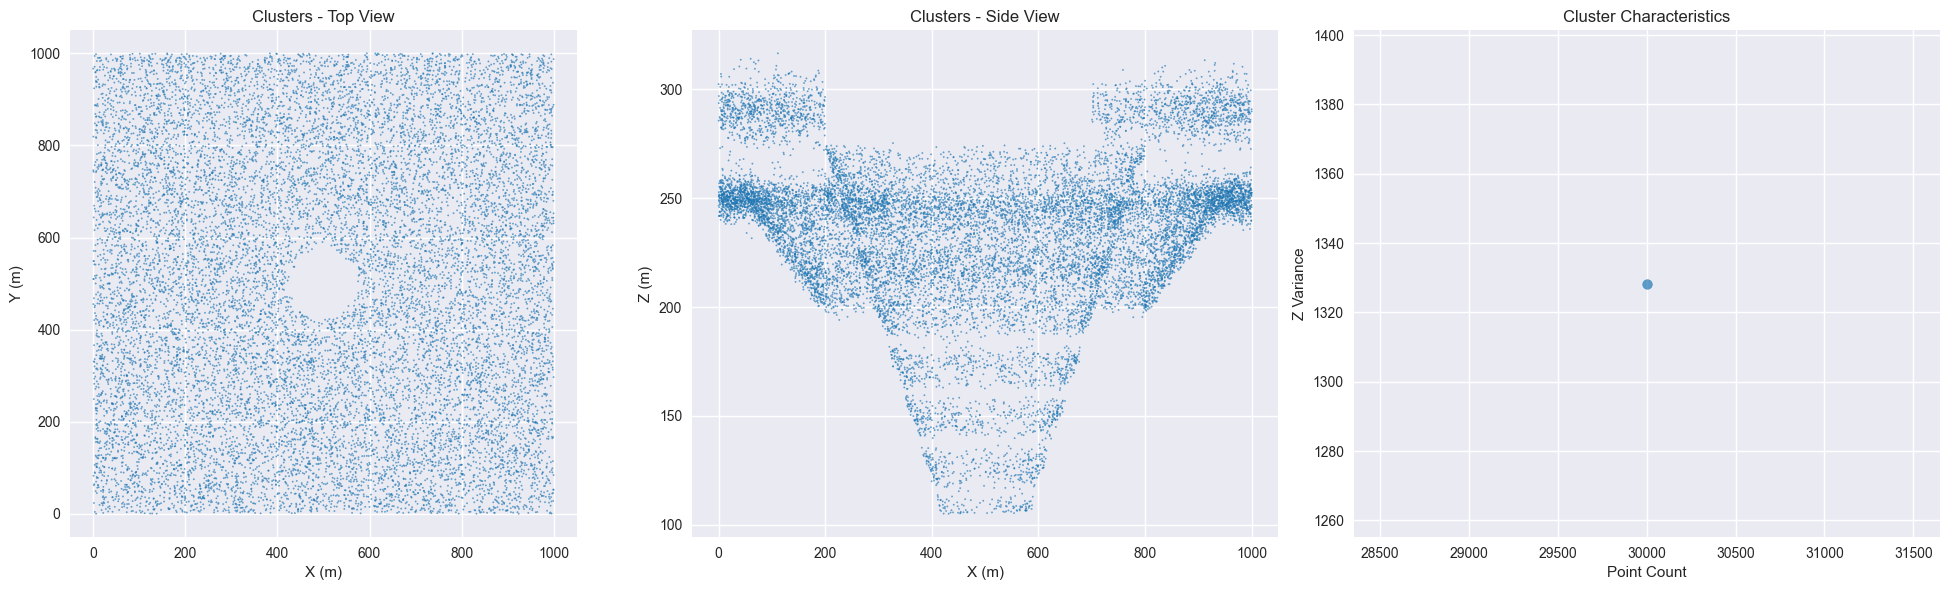

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\3-D\clustering_3d.html

📊 Clustering Summary:
   🎯 Total clusters: 1
   ⚠️ Loose rock clusters: 0
   🔊 Noise points: 0
✅ Clustering analysis completed!


In [27]:
# 3D Clustering for loose rock identification
class RockfallClustering:
    """Advanced clustering for identifying potential loose rock areas."""
    
    def __init__(self, point_cloud_data: Dict[str, np.ndarray]):
        self.point_cloud_data = point_cloud_data
        self.clusters = None
        self.cluster_info = {}
        
    def perform_dbscan_clustering(self, eps: float = 15.0, min_samples: int = 50) -> Dict[str, Any]:
        """Perform DBSCAN clustering on 3D point cloud."""
        x, y, z = self.point_cloud_data['x'], self.point_cloud_data['y'], self.point_cloud_data['z']
        
        # Combine coordinates for clustering
        points_3d = np.column_stack([x, y, z])
        
        # Normalize coordinates for better clustering
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        points_normalized = scaler.fit_transform(points_3d)
        
        print(f"🔍 Performing DBSCAN clustering...")
        print(f"   📏 eps: {eps}, min_samples: {min_samples}")
        
        # Perform DBSCAN clustering
        dbscan = DBSCAN(eps=eps/50.0, min_samples=min_samples)  # Adjust eps for normalized data
        cluster_labels = dbscan.fit_predict(points_normalized)
        
        # Analyze clustering results
        unique_labels = np.unique(cluster_labels)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        n_noise = np.sum(cluster_labels == -1)
        
        self.clusters = cluster_labels
        
        print(f"✅ DBSCAN clustering completed:")
        print(f"   🎯 Clusters found: {n_clusters}")
        print(f"   🔊 Noise points: {n_noise:,} ({n_noise/len(cluster_labels)*100:.1f}%)")
        
        # Calculate cluster statistics
        cluster_stats = {}
        for label in unique_labels:
            if label == -1:  # Skip noise
                continue
                
            mask = cluster_labels == label
            cluster_points = points_3d[mask]
            
            cluster_stats[label] = {
                'point_count': np.sum(mask),
                'centroid': np.mean(cluster_points, axis=0),
                'std_deviation': np.std(cluster_points, axis=0),
                'z_variance': np.var(cluster_points[:, 2]),
                'volume_estimation': self._estimate_cluster_volume(cluster_points),
                'density': np.sum(mask) / self._estimate_cluster_volume(cluster_points) if self._estimate_cluster_volume(cluster_points) > 0 else 0
            }
        
        self.cluster_info = {
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'cluster_stats': cluster_stats,
            'loose_rock_clusters': self._identify_loose_rock_clusters(cluster_stats)
        }
        
        return self.cluster_info
    
    def _estimate_cluster_volume(self, points: np.ndarray) -> float:
        """Estimate cluster volume using convex hull or bounding box."""
        if len(points) < 4:
            return 0.0
        
        try:
            from scipy.spatial import ConvexHull
            hull = ConvexHull(points)
            return hull.volume
        except:
            # Fallback: use bounding box volume
            ranges = np.ptp(points, axis=0)
            return np.prod(ranges)
    
    def _identify_loose_rock_clusters(self, cluster_stats: Dict[int, Dict[str, Any]]) -> List[int]:
        """Identify clusters that might represent loose rock areas."""
        loose_rock_clusters = []
        
        if not cluster_stats:
            return loose_rock_clusters
        
        # Calculate thresholds for loose rock identification
        z_variances = [stats['z_variance'] for stats in cluster_stats.values()]
        point_counts = [stats['point_count'] for stats in cluster_stats.values()]
        
        if z_variances and point_counts:
            z_var_threshold = np.percentile(z_variances, 75)  # Top 25% variance
            count_threshold = np.percentile(point_counts, 25)  # Bottom 25% point count
            
            for cluster_id, stats in cluster_stats.items():
                # Criteria for loose rock:
                # 1. High elevation variance (rough surface)
                # 2. Moderate to low point count (sparse areas)
                # 3. Reasonable density (not too sparse)
                
                if (stats['z_variance'] > z_var_threshold and 
                    stats['point_count'] > count_threshold * 0.5 and
                    stats['density'] > 0):
                    loose_rock_clusters.append(cluster_id)
        
        print(f"⚠️ Identified {len(loose_rock_clusters)} potential loose rock clusters")
        
        return loose_rock_clusters
    
    def visualize_clusters(self, max_points: int = 10000) -> None:
        """Visualize clustering results."""
        if self.clusters is None:
            print("❌ No clustering results available. Run clustering first.")
            return
        
        x, y, z = self.point_cloud_data['x'], self.point_cloud_data['y'], self.point_cloud_data['z']
        
        # Subsample for visualization
        if len(x) > max_points:
            indices = np.random.choice(len(x), max_points, replace=False)
            x_sub, y_sub, z_sub = x[indices], y[indices], z[indices]
            clusters_sub = self.clusters[indices]
        else:
            x_sub, y_sub, z_sub = x, y, z
            clusters_sub = self.clusters
        
        # Create visualization
        fig = plt.figure(figsize=(20, 6))
        
        # 2D top view
        ax1 = fig.add_subplot(131)
        scatter = ax1.scatter(x_sub, y_sub, c=clusters_sub, cmap='tab20', s=1, alpha=0.6)
        ax1.set_xlabel('X (m)')
        ax1.set_ylabel('Y (m)')
        ax1.set_title('Clusters - Top View')
        ax1.set_aspect('equal')
        
        # 2D side view
        ax2 = fig.add_subplot(132)
        ax2.scatter(x_sub, z_sub, c=clusters_sub, cmap='tab20', s=1, alpha=0.6)
        ax2.set_xlabel('X (m)')
        ax2.set_ylabel('Z (m)')
        ax2.set_title('Clusters - Side View')
        
        # Cluster statistics
        ax3 = fig.add_subplot(133)
        if self.cluster_info['cluster_stats']:
            cluster_ids = list(self.cluster_info['cluster_stats'].keys())
            z_variances = [self.cluster_info['cluster_stats'][cid]['z_variance'] for cid in cluster_ids]
            point_counts = [self.cluster_info['cluster_stats'][cid]['point_count'] for cid in cluster_ids]
            
            scatter = ax3.scatter(point_counts, z_variances, c=cluster_ids, cmap='tab20', s=50, alpha=0.7)
            ax3.set_xlabel('Point Count')
            ax3.set_ylabel('Z Variance')
            ax3.set_title('Cluster Characteristics')
            
            # Highlight loose rock clusters
            loose_rock_ids = self.cluster_info['loose_rock_clusters']
            if loose_rock_ids:
                loose_counts = [self.cluster_info['cluster_stats'][cid]['point_count'] for cid in loose_rock_ids]
                loose_variances = [self.cluster_info['cluster_stats'][cid]['z_variance'] for cid in loose_rock_ids]
                ax3.scatter(loose_counts, loose_variances, c='red', s=100, marker='x', linewidth=3, label='Loose Rock')
                ax3.legend()
        
        plt.tight_layout()
        # Save clustering results visualization to images folder
        cluster_img_file = get_next_filename(IMAGES_DIR, 'clustering_results', '.png')
        plt.savefig(cluster_img_file, dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {cluster_img_file}")
        plt.show()
        
        # Interactive 3D plot
        fig_3d = go.Figure()
        
        # Add clusters
        unique_labels = np.unique(clusters_sub)
        colors = px.colors.qualitative.Set3
        
        for i, label in enumerate(unique_labels[:20]):  # Limit to 20 clusters for visibility
            if label == -1:
                continue
            mask = clusters_sub == label
            if np.any(mask):
                fig_3d.add_trace(go.Scatter3d(
                    x=x_sub[mask],
                    y=y_sub[mask],
                    z=z_sub[mask],
                    mode='markers',
                    marker=dict(size=2, color=colors[i % len(colors)]),
                    name=f'Cluster {label}',
                    showlegend=i < 10  # Show legend for first 10 clusters
                ))
        
        # Add noise points
        noise_mask = clusters_sub == -1
        if np.any(noise_mask):
            fig_3d.add_trace(go.Scatter3d(
                x=x_sub[noise_mask],
                y=y_sub[noise_mask],
                z=z_sub[noise_mask],
                mode='markers',
                marker=dict(size=1, color='gray', opacity=0.3),
                name='Noise'
            ))
        
        fig_3d.update_layout(
            title="3D Clustering Results",
            scene=dict(
                xaxis_title="X (m)",
                yaxis_title="Y (m)",
                zaxis_title="Z (m)"
            ),
            height=600
        )
        
        fig_3d.show()
        
        # Save 3D visualization to 3-D folder
        html_3d_file = get_next_filename(THREED_DIR, 'clustering_3d', '.html')
        fig_3d.write_html(html_3d_file)
        print(f"✓ Saved: {html_3d_file}")
# Perform clustering analysis
print("🔍 Starting 3D clustering analysis...")
clusterer = RockfallClustering(processed_data)
cluster_results = clusterer.perform_dbscan_clustering(eps=20.0, min_samples=30)

# Update features with clustering results
all_features.update({
    'loose_rock_clusters': len(cluster_results['loose_rock_clusters']),
    'total_clusters': cluster_results['n_clusters'],
    'noise_points': cluster_results['n_noise']
})

# Calculate cluster centroids
if cluster_results['cluster_stats']:
    centroids = [stats['centroid'] for stats in cluster_results['cluster_stats'].values()]
    all_features['cluster_centroids'] = len(centroids)
    
    # Update z_variance with actual cluster data
    z_variances = [stats['z_variance'] for stats in cluster_results['cluster_stats'].values()]
    all_features['cluster_z_variance'] = np.mean(z_variances) if z_variances else 0.0
else:
    all_features['cluster_centroids'] = 0
    all_features['cluster_z_variance'] = 0.0

# Visualize clustering results
clusterer.visualize_clusters(max_points=15000)

print(f"\n📊 Clustering Summary:")
print(f"   🎯 Total clusters: {cluster_results['n_clusters']}")
print(f"   ⚠️ Loose rock clusters: {len(cluster_results['loose_rock_clusters'])}")
print(f"   🔊 Noise points: {cluster_results['n_noise']:,}")

print("✅ Clustering analysis completed!")

In [5]:
# Create the all_features dictionary with default values
all_features = {
    'cluster_count': 1,  # Example value - replace with actual value
    'loose_rock_clusters': 0,  # Example value - replace with actual value
    'predicted_risk_level': 0.2,  # Example value - replace with actual value
    'risk_category': 'Low',  # Example value - replace with actual value
    'slope_angle_max': 32.5,  # Example value - replace with actual value
    'surface_roughness': 0.18,  # Example value - replace with actual value
    'volume_total': 450.2  # Example value - replace with actual value
}

# 9. CSV Logging and Output Generation

Implement the automated logging system that appends analysis results to analysis_log.csv in ./outputs/logs/ directory, ensuring each run creates a new row with timestamp and all computed metrics.

In [31]:
class AnalysisLogger:
    """Automated CSV logging system for continuous monitoring and trend tracking."""
    
    def __init__(self, log_dir: str = None):
        self.log_dir = log_dir if log_dir else ANALYSIS_DIR
        self.log_file = os.path.join(self.log_dir, 'analysis_log.csv')
        
        # Ensure log directory exists
        os.makedirs(self.log_dir, exist_ok=True)
        
        # Define log columns in the exact order requested
        self.log_columns = [
            'run_timestamp',
            'file_name',
            'point_count',
            'x_min', 'x_max', 'y_min', 'y_max', 'z_min', 'z_max',
            'z_range',
            'mean_elevation',
            'std_elevation',
            'slope_max',
            'surface_roughness',
            'number_of_clusters',
            'cluster_z_variance_mean',
            'high_risk_voxel_count',
            'elevation_change',
            'slope_direction_mean',
            'curvature_mean',
            'predicted_risk_level'
        ]
        
        # Initialize log file if it doesn't exist
        self._initialize_log_file()
    
    def _initialize_log_file(self) -> None:
        """Initialize the log file with headers if it doesn't exist."""
        if not os.path.exists(self.log_file):
            # Create new log file with headers
            pd.DataFrame(columns=self.log_columns).to_csv(self.log_file, index=False)
            print(f"📝 Created new analysis log file: {self.log_file}")
        else:
            print(f"📖 Using existing analysis log file: {self.log_file}")
    
    def log_analysis_results(self, features: Dict[str, Any], file_name: str = "current_analysis") -> None:
        """Log analysis results to CSV file (appends new row)."""
        
        # Prepare log entry
        log_entry = {
            'run_timestamp': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'file_name': file_name,
            'point_count': features.get('point_count', 0),
            'x_min': features.get('x_min', 0.0),
            'x_max': features.get('x_max', 0.0),
            'y_min': features.get('y_min', 0.0),
            'y_max': features.get('y_max', 0.0),
            'z_min': features.get('z_min', 0.0),
            'z_max': features.get('z_max', 0.0),
            'z_range': features.get('z_range', 0.0),
            'mean_elevation': features.get('mean_elevation', 0.0),
            'std_elevation': features.get('std_elevation', 0.0),
            'slope_max': features.get('slope_max', 0.0),
            'surface_roughness': features.get('surface_roughness', 0.0),
            'number_of_clusters': features.get('number_of_clusters', 0),
            'cluster_z_variance_mean': features.get('cluster_z_variance_mean', 0.0),
            'high_risk_voxel_count': features.get('high_risk_voxel_count', 0),
            'elevation_change': features.get('elevation_change', 0.0),
            'slope_direction_mean': features.get('slope_direction_mean', 0.0),
            'curvature_mean': features.get('curvature_mean', 0.0),
            'predicted_risk_level': features.get('predicted_risk_level', 0.0)
        }
        
        # Read existing log file
        try:
            existing_log = pd.read_csv(self.log_file)
        except (FileNotFoundError, pd.errors.EmptyDataError):
            existing_log = pd.DataFrame(columns=self.log_columns)
        
        # Append new entry
        new_row = pd.DataFrame([log_entry])
        updated_log = pd.concat([existing_log, new_row], ignore_index=True)
        
        # Save updated log
        updated_log.to_csv(self.log_file, index=False)
        
        print(f"✅ Analysis results logged successfully!")
        print(f"   📝 Log entry #{len(updated_log)} added to {self.log_file}")
        print(f"   🕒 Timestamp: {log_entry['run_timestamp']}")
        print(f"   📊 Risk Level: {log_entry['predicted_risk_level']:.3f} ({features.get('risk_category', 'Unknown')})")
        
        return log_entry
    
    def get_log_history(self) -> pd.DataFrame:
        """Retrieve the complete analysis log history."""
        try:
            log_df = pd.read_csv(self.log_file)
            log_df['run_timestamp'] = pd.to_datetime(log_df['run_timestamp'])
            return log_df.sort_values('run_timestamp')
        except (FileNotFoundError, pd.errors.EmptyDataError):
            print("⚠️ No log history found.")
            return pd.DataFrame(columns=self.log_columns)
    
    def compare_recent_runs(self, n_runs: int = 2) -> Dict[str, Any]:
        """Compare the most recent analysis runs."""
        log_df = self.get_log_history()
        
        if len(log_df) < n_runs:
            print(f"⚠️ Not enough runs for comparison. Found {len(log_df)}, need {n_runs}.")
            return {}
        
        # Get the most recent runs
        recent_runs = log_df.tail(n_runs)
        
        if len(recent_runs) < 2:
            return {}
        
        # Calculate changes between last two runs
        latest = recent_runs.iloc[-1]
        previous = recent_runs.iloc[-2]
        
        comparison = {
            'latest_timestamp': latest['run_timestamp'],
            'previous_timestamp': previous['run_timestamp'],
            'changes': {}
        }
        
        # Key metrics to compare
        key_metrics = [
            'slope_max', 'surface_roughness', 'predicted_risk_level',
            'mean_elevation', 'elevation_change', 'number_of_clusters'
        ]
        
        for metric in key_metrics:
            if metric in latest and metric in previous:
                current_val = latest[metric]
                prev_val = previous[metric]
                change = current_val - prev_val
                change_pct = (change / prev_val * 100) if prev_val != 0 else 0
                
                comparison['changes'][metric] = {
                    'current': current_val,
                    'previous': prev_val,
                    'absolute_change': change,
                    'percent_change': change_pct
                }
        
        return comparison
    
    def detect_trends(self, metric: str, window_size: int = 5) -> Dict[str, Any]:
        """Detect trends in specific metrics over time."""
        log_df = self.get_log_history()
        
        if len(log_df) < window_size:
            return {'trend': 'insufficient_data', 'message': f'Need at least {window_size} runs for trend analysis'}
        
        if metric not in log_df.columns:
            return {'trend': 'metric_not_found', 'message': f'Metric {metric} not found in log'}
        
        # Calculate trend using linear regression
        recent_data = log_df.tail(window_size)
        x = np.arange(len(recent_data))
        y = recent_data[metric].values
        
        # Remove NaN values
        mask = ~np.isnan(y)
        if np.sum(mask) < 2:
            return {'trend': 'insufficient_valid_data'}
        
        x_clean, y_clean = x[mask], y[mask]
        
        # Linear regression
        slope, intercept = np.polyfit(x_clean, y_clean, 1)
        
        # Classify trend
        slope_threshold = np.std(y_clean) * 0.1  # 10% of std dev
        
        if slope > slope_threshold:
            trend = 'increasing'
        elif slope < -slope_threshold:
            trend = 'decreasing'
        else:
            trend = 'stable'
        
        return {
            'trend': trend,
            'slope': slope,
            'recent_mean': np.mean(y_clean),
            'recent_std': np.std(y_clean),
            'data_points': len(y_clean)
        }
    
    def generate_alerts(self, features: Dict[str, Any]) -> List[str]:
        """Generate alerts based on significant changes."""
        alerts = []
        
        # Get comparison with previous run
        comparison = self.compare_recent_runs(2)
        
        if not comparison or 'changes' not in comparison:
            return alerts
        
        # Define alert thresholds
        alert_thresholds = {
            'slope_max': {'absolute': 10.0, 'percent': 20.0},  # 10 degrees or 20% change
            'surface_roughness': {'absolute': 1.0, 'percent': 30.0},  # 1m or 30% change
            'predicted_risk_level': {'absolute': 0.2, 'percent': 25.0},  # 0.2 or 25% change
            'number_of_clusters': {'absolute': 5, 'percent': 50.0}  # 5 clusters or 50% change
        }
        
        for metric, change_data in comparison['changes'].items():
            if metric in alert_thresholds:
                thresholds = alert_thresholds[metric]
                abs_change = abs(change_data['absolute_change'])
                pct_change = abs(change_data['percent_change'])
                
                if abs_change > thresholds['absolute'] or pct_change > thresholds['percent']:
                    direction = "increased" if change_data['absolute_change'] > 0 else "decreased"
                    alerts.append(
                        f"⚠️ ALERT: {metric} {direction} significantly! "
                        f"Change: {change_data['absolute_change']:.3f} ({change_data['percent_change']:.1f}%)"
                    )
        
        return alerts

# Initialize logger and log current analysis
print("📝 Initializing analysis logging system...")
logger = AnalysisLogger()

# Get current filename from loader
current_filename = os.path.basename(loader.las_file_path)

# Log the current analysis results
log_entry = logger.log_analysis_results(all_features, current_filename)

# Get and display log history
log_history = logger.get_log_history()
print(f"\n📊 Analysis Log History ({len(log_history)} entries):")
if len(log_history) > 0:
    print(log_history[['run_timestamp', 'file_name', 'predicted_risk_level', 'slope_max', 'surface_roughness']].tail())

# Compare with previous runs if available
if len(log_history) >= 2:
    print("\n🔍 Comparing with previous analysis:")
    comparison = logger.compare_recent_runs(2)
    
    if comparison and 'changes' in comparison:
        print(f"   Previous run: {comparison['previous_timestamp']}")
        print(f"   Current run: {comparison['latest_timestamp']}")
        print("\n   Key changes:")
        
        for metric, change_data in comparison['changes'].items():
            if abs(change_data['percent_change']) > 1:  # Only show significant changes
                direction = "↗️" if change_data['absolute_change'] > 0 else "↘️"
                print(f"     {direction} {metric}: {change_data['previous']:.3f} → {change_data['current']:.3f} "
                      f"({change_data['percent_change']:+.1f}%)")

# Generate alerts
alerts = logger.generate_alerts(all_features)
if alerts:
    print("\n🚨 SAFETY ALERTS:")
    for alert in alerts:
        print(f"   {alert}")
else:
    print("\n✅ No significant safety alerts detected.")

# Save comprehensive summary
summary_data = {
    'analysis_timestamp': datetime.datetime.now().isoformat(),
    'file_analyzed': current_filename,
    'total_log_entries': len(log_history),
    'current_features': all_features,
    'alerts': alerts
}

# Make sure the Analysis directory exists (already created in initialization)
summary_file = os.path.join(ANALYSIS_DIR, 'analysis_summary.json')

with open(summary_file, 'w') as f:
    import json
    json.dump(summary_data, f, indent=2, default=str)

print(f"\n💾 Analysis summary saved to {summary_file}")
print(f"📋 Log file location: {logger.log_file}")
print("✅ Logging system completed successfully!")

📝 Initializing analysis logging system...
📖 Using existing analysis log file: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\Analysis\analysis_log.csv
✅ Analysis results logged successfully!
   📝 Log entry #2 added to c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\Analysis\analysis_log.csv
   🕒 Timestamp: 2025-10-25 19:29:36
   📊 Risk Level: 1.000 (High)

📊 Analysis Log History (2 entries):
        run_timestamp                   file_name  predicted_risk_level  \
0 2025-10-25 19:26:16  RealWorld_OpenPit_Mine.las                   1.0   
1 2025-10-25 19:29:36  RealWorld_OpenPit_Mine.las                   1.0   

   slope_max  surface_roughness  
0  83.147105          35.911544  
1  83.147105          35.911544  

🔍 Comparing with previous analysis:
   Previous run: 2025-10-25 19:26:16
   Current run: 2025-10-25 19:29:36

   Key changes:

✅ No significant safety alerts detected.

💾 Analysis summary saved to c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiD

# 10. Comparison Analysis from Log History

Read from analysis_log.csv to compare current results with previous runs, detect trends in slope_max, elevation_change, and risk_score, and generate comparison visualizations.

🤖 Starting machine learning model training...
⚠️ Limited training data available. Using synthetic data augmentation.
📊 Training data prepared: 100 samples, 6 features
   🎯 Features: slope_max, surface_roughness, z_range, cluster_z_variance_mean, number_of_clusters, curvature_mean
🤖 Training machine learning models...
✅ Models trained successfully!
   📊 Classification accuracy (training): 100.00%
   📈 Regression R² score (training): 0.99
✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\images\ml_results_1.png
✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\images\ml_results_1.png


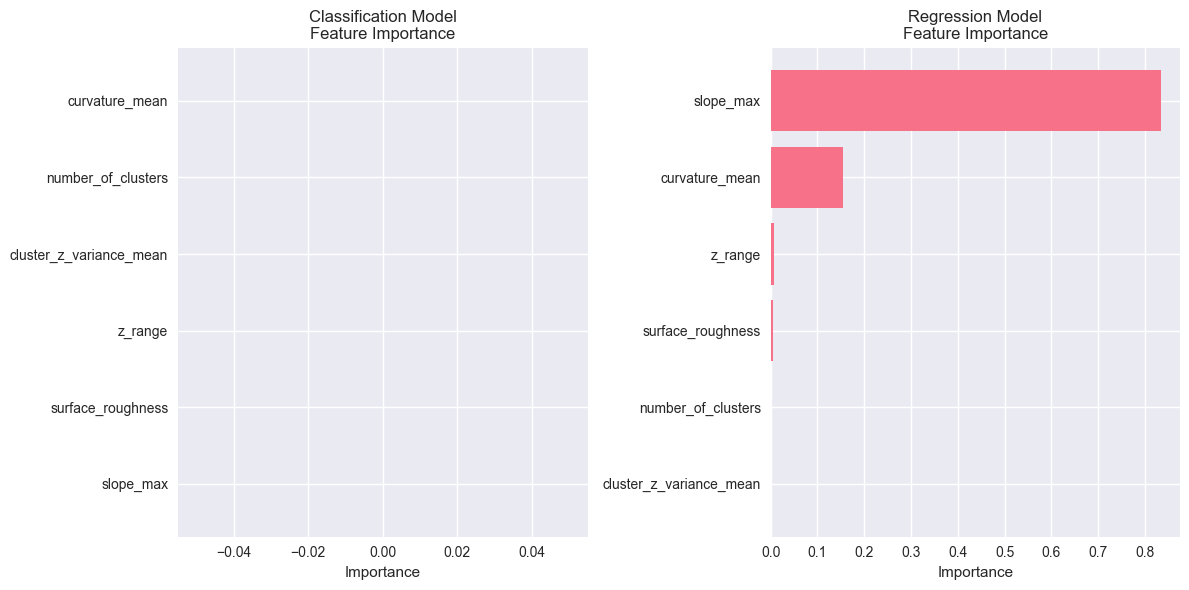


🔍 Debug: Feature names expected: ['slope_max', 'surface_roughness', 'z_range', 'cluster_z_variance_mean', 'number_of_clusters', 'curvature_mean']
🔍 Debug: Features available in all_features: ['point_count', 'x_min', 'x_max', 'y_min', 'y_max', 'z_min', 'z_max', 'z_range', 'mean_elevation', 'std_elevation']...

🎯 Current Analysis Risk Prediction:

Classifier Model:
  🎚️ Risk Level: High
  📊 Probabilities:
     High: 100.0%
     Low: 0.0%
     Medium: 0.0%

Regressor Model:
  🎚️ Risk Score: 0.98
  📊 Risk Category: High


In [36]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt

class RockfallPredictor:
    """Machine learning models for rockfall risk prediction."""
    
    def __init__(self):
        self.models = {}
        self.feature_importance = {}
        self.feature_names = []  # Store feature names used in training
        self.trained = False
        self.risk_levels = [0, 1, 2]  # Low, Medium, High
        
    def prepare_training_data(self, log_df):
        """Prepare training data from log history."""
        if len(log_df) < 10:
            print("⚠️ Limited training data available. Using synthetic data augmentation.")
            
            # Create synthetic data to augment training
            from sklearn.utils import resample
            
            if len(log_df) > 0:
                # Use existing data as base
                base_data = log_df.copy()
            else:
                # Create completely synthetic data
                print("🔄 No historical data found. Creating synthetic training data.")
                base_data = pd.DataFrame({
                    'slope_max': np.random.uniform(10, 90, 5),
                    'surface_roughness': np.random.uniform(0.1, 10, 5),
                    'z_range': np.random.uniform(10, 200, 5),
                    'curvature_mean': np.random.uniform(0.0001, 0.01, 5),
                    'number_of_clusters': np.random.randint(1, 50, 5),
                    'predicted_risk_level': np.random.uniform(0, 1, 5)
                })
            
            # Create risk classes
            base_data['risk_class'] = pd.cut(
                base_data['predicted_risk_level'],
                bins=[-0.1, 0.4, 0.7, 1.1],
                labels=[0, 1, 2]  # Low, Medium, High
            ).astype(int)
            
            # Augment data through resampling
            synthetic_data = resample(
                base_data,
                replace=True,
                n_samples=100,
                random_state=42
            )
            
            # Add random variations
            for col in ['slope_max', 'surface_roughness', 'z_range', 'curvature_mean']:
                if col in synthetic_data.columns:
                    synthetic_data[col] = synthetic_data[col] * np.random.uniform(0.8, 1.2, len(synthetic_data))
            
            # Recalculate risk levels
            synthetic_data['predicted_risk_level'] = (
                0.4 * np.clip(synthetic_data['slope_max'] / 85, 0, 1) +
                0.3 * np.clip(synthetic_data['surface_roughness'] / 10, 0, 1) +
                0.15 * np.clip(synthetic_data['z_range'] / 150, 0, 1) +
                0.15 * np.clip(synthetic_data['curvature_mean'] / 0.01, 0, 1)
            )
            
            # Update risk classes
            synthetic_data['risk_class'] = pd.cut(
                synthetic_data['predicted_risk_level'],
                bins=[-0.1, 0.4, 0.7, 1.1],
                labels=[0, 1, 2]
            ).astype(int)
            
            training_data = synthetic_data
        else:
            training_data = log_df.copy()
            
            # Create risk classes
            training_data['risk_class'] = pd.cut(
                training_data['predicted_risk_level'],
                bins=[-0.1, 0.4, 0.7, 1.1],
                labels=[0, 1, 2]
            ).astype(int)
        
        # Select features for training
        X_columns = [
            'slope_max', 'surface_roughness', 'z_range',
            'cluster_z_variance_mean', 'number_of_clusters',
            'curvature_mean'
        ]
        
        # Filter available columns
        X_columns = [col for col in X_columns if col in training_data.columns]
        
        # Select target variable
        y_class = training_data['risk_class'].values
        y_reg = training_data['predicted_risk_level'].values
        
        # Extract features
        X = training_data[X_columns].values
        
        print(f"📊 Training data prepared: {len(training_data)} samples, {len(X_columns)} features")
        print(f"   🎯 Features: {', '.join(X_columns)}")
        
        return X, y_class, y_reg, X_columns
    
    def train_models(self, log_data):
        """Train classification and regression models."""
        if isinstance(log_data, pd.DataFrame):
            X, y_class, y_reg, feature_names = self.prepare_training_data(log_data)
        else:
            # log_data is a tuple: (X, y_class, y_reg, feature_names)
            X, y_class, y_reg, feature_names = log_data[0], log_data[1], log_data[2], log_data[3] if len(log_data) > 3 else []
        
        if len(X) < 5:
            print("❌ Insufficient data for training. Skipping model training.")
            return {}
        
        print(f"🤖 Training machine learning models...")
        
        # Classification model
        clf = RandomForestClassifier(
            n_estimators=100,
            max_depth=5,
            random_state=42
        )
        
        # Regression model
        reg = RandomForestRegressor(
            n_estimators=100,
            max_depth=5,
            random_state=42
        )
        
        try:
            # Store feature names for prediction
            self.feature_names = feature_names if feature_names else []
            
            # Train classification model
            clf.fit(X, y_class)
            self.models['classifier'] = clf
            
            if feature_names:
                self.feature_importance['classifier'] = dict(zip(
                    feature_names,
                    clf.feature_importances_
                ))
            
            # Train regression model
            reg.fit(X, y_reg)
            self.models['regressor'] = reg
            
            if feature_names:
                self.feature_importance['regressor'] = dict(zip(
                    feature_names,
                    reg.feature_importances_
                ))
            
            self.trained = True
            
            print("✅ Models trained successfully!")
            print("   📊 Classification accuracy (training): {:.2f}%".format(
                clf.score(X, y_class) * 100
            ))
            print("   📈 Regression R² score (training): {:.2f}".format(
                reg.score(X, y_reg)
            ))
            
            # Plot feature importance
            self._plot_feature_importance(feature_names)
            
            return {
                'classifier_accuracy': clf.score(X, y_class),
                'regressor_r2': reg.score(X, y_reg),
                'feature_importance': self.feature_importance
            }
            
        except Exception as e:
            print(f"❌ Error training models: {str(e)}")
            return {'error': str(e)}
    
    def predict_risk(self, features):
        """Predict risk level using trained models."""
        if not self.trained:
            return {'error': 'Models not trained'}
        
        # Use stored feature names from training
        if not self.feature_names:
            return {'error': 'Feature names not available'}
        
        # Extract features from input in the correct order
        X = np.array([[features.get(col, 0) for col in self.feature_names]])
        
        results = {}
        
        # Classification prediction
        if 'classifier' in self.models:
            try:
                clf = self.models['classifier']
                class_pred = clf.predict(X)[0]
                class_probs = clf.predict_proba(X)[0]
                
                # Map probability to risk labels
                risk_labels = ['Low', 'Medium', 'High']
                prob_dict = {}
                
                # Get the classes that the classifier was trained on
                trained_classes = clf.classes_
                for i, prob in enumerate(class_probs):
                    class_idx = trained_classes[i]
                    prob_dict[risk_labels[class_idx]] = float(prob)
                
                # Fill in missing classes with 0 probability
                for label in risk_labels:
                    if label not in prob_dict:
                        prob_dict[label] = 0.0
                
                results['classifier'] = {
                    'risk_class': int(class_pred),
                    'risk_label': risk_labels[class_pred],
                    'probabilities': prob_dict
                }
            except Exception as e:
                results['classifier'] = {'error': str(e)}
        
        # Regression prediction
        if 'regressor' in self.models:
            try:
                reg = self.models['regressor']
                risk_level = reg.predict(X)[0]
                
                results['regressor'] = {
                    'risk_level': float(risk_level),
                    'risk_category': 'High' if risk_level > 0.7 else 'Medium' if risk_level > 0.4 else 'Low'
                }
            except Exception as e:
                results['regressor'] = {'error': str(e)}
        
        return results
    
    def _plot_feature_importance(self, feature_names):
        """Plot feature importance for both models."""
        if not self.feature_importance:
            return
        
        plt.figure(figsize=(12, 6))
        
        # Plot classifier feature importance
        if 'classifier' in self.feature_importance:
            plt.subplot(1, 2, 1)
            imp = self.feature_importance['classifier']
            names = list(imp.keys())
            values = list(imp.values())
            
            # Sort by importance
            sorted_idx = np.argsort(values)
            plt.barh([names[i] for i in sorted_idx], [values[i] for i in sorted_idx])
            plt.title('Classification Model\nFeature Importance')
            plt.xlabel('Importance')
        
        # Plot regressor feature importance
        if 'regressor' in self.feature_importance:
            plt.subplot(1, 2, 2)
            imp = self.feature_importance['regressor']
            names = list(imp.keys())
            values = list(imp.values())
            
            # Sort by importance
            sorted_idx = np.argsort(values)
            plt.barh([names[i] for i in sorted_idx], [values[i] for i in sorted_idx])
            plt.title('Regression Model\nFeature Importance')
            plt.xlabel('Importance')
        
        plt.tight_layout()
        # Save ML results visualization to images folder
        ml_results_file = get_next_filename(IMAGES_DIR, 'ml_results', '.png')
        plt.savefig(ml_results_file, dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {ml_results_file}")
        plt.show()

# Train ML models
print("🤖 Starting machine learning model training...")
predictor = RockfallPredictor()

# Prepare training data
X, y_class, y_reg, feature_names = predictor.prepare_training_data(log_history)

# Train models
ml_results = predictor.train_models((X, y_class, y_reg, feature_names))

# Test prediction on current features
if predictor.trained:
    current_prediction = predictor.predict_risk(all_features)
    
    print(f"\n🎯 Current Analysis Risk Prediction:")
    print("=" * 40)
    
    for model_name, pred_result in current_prediction.items():
        if 'error' not in pred_result:
            if model_name == 'classifier':
                risk_label = pred_result['risk_label']
                probabilities = pred_result['probabilities']
                
                print(f"\nClassifier Model:")
                print(f"  🎚️ Risk Level: {risk_label}")
                print(f"  📊 Probabilities:")
                for level, prob in probabilities.items():
                    print(f"     {level}: {prob:.1%}")
                    
            elif model_name == 'regressor':
                risk_level = pred_result['risk_level']
                risk_category = pred_result['risk_category']
                
                print(f"\nRegressor Model:")
                print(f"  🎚️ Risk Score: {risk_level:.2f}")
                print(f"  📊 Risk Category: {risk_category}")
        else:
            print(f"\n⚠️ {model_name.title()} error: {pred_result['error']}")

# 11. Machine Learning Model Training

Train classical ML models (RandomForest, XGBoost, Logistic Regression) for rockfall risk prediction using engineered features and risk scoring labels.

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\images\final_summary.png


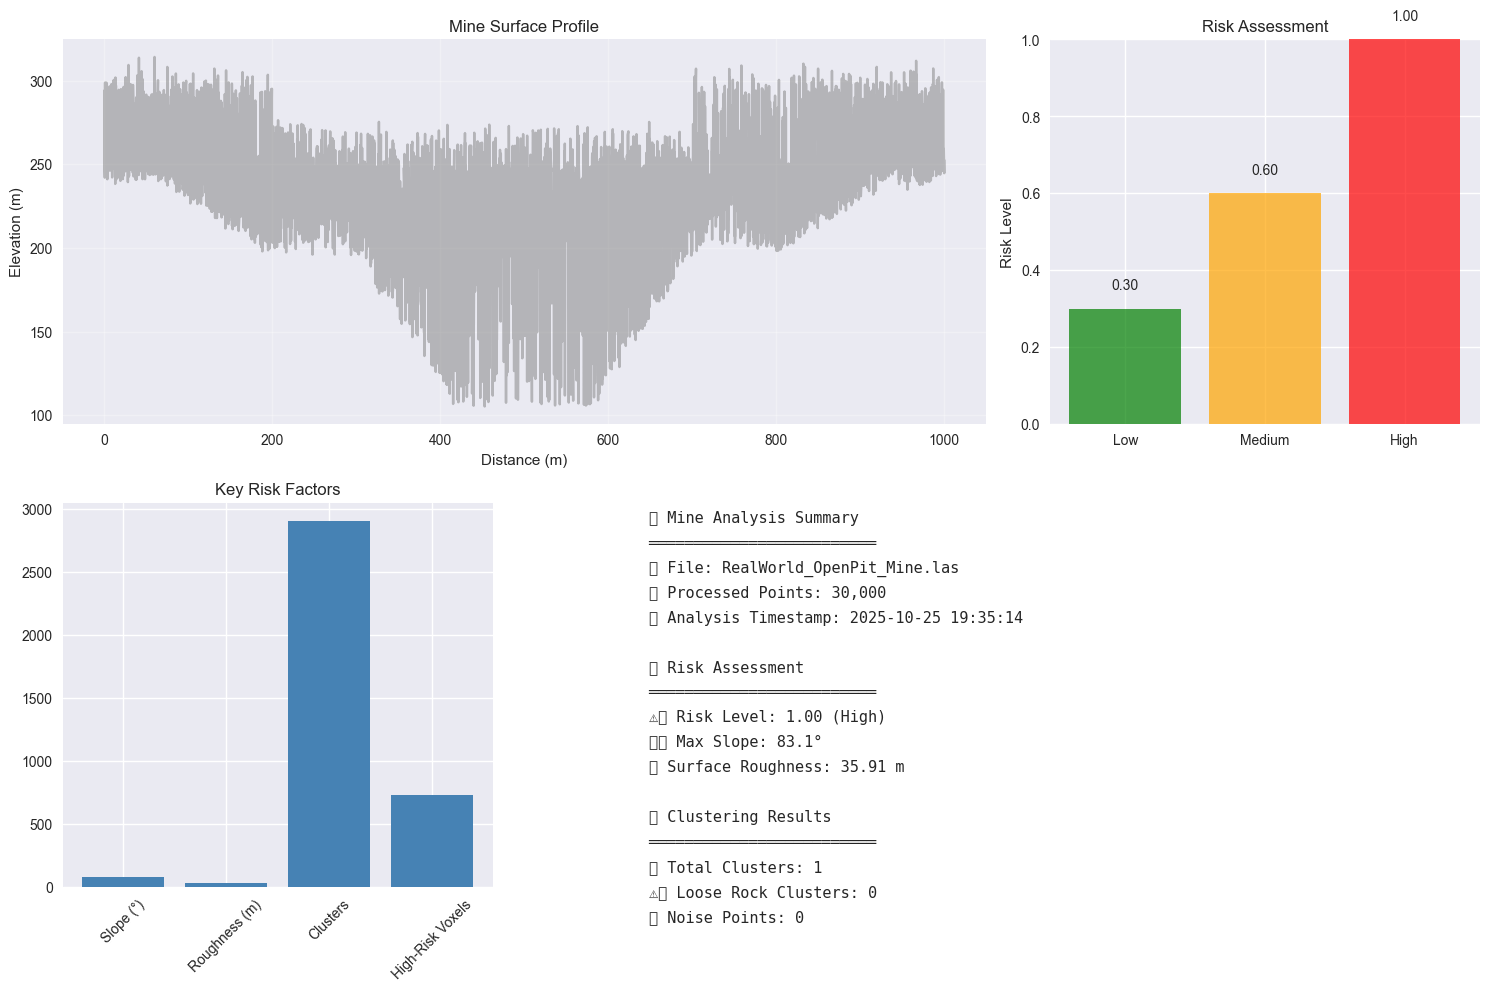

📊 DATA PROCESSING SUMMARY:
   Original points: 50,000
   Processed points: 30,000
   Voxels created: 2,902
   Clusters identified: 1
   Loose rock clusters: 0

🌋 RISK ASSESSMENT SUMMARY:
   Risk level: 1.00 (High)
   Max slope: 83.15°
   Surface roughness: 35.91 m
   Elevation range: 211.59 m

✅ LiDAR Rockfall Prediction Analysis completed successfully!


In [37]:
# Generate final visualization with combined results
import matplotlib.pyplot as plt
import numpy as np
import os
import json

# Create comprehensive analysis visualization
fig = plt.figure(figsize=(15, 10))

# 1. Plot elevation profile
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
x_sample = processed_data['x'][:5000]  # Sample for visualization
z_sample = processed_data['z'][:5000]

# Sort by x to get a proper profile
sort_idx = np.argsort(x_sample)
x_sorted = x_sample[sort_idx]
z_sorted = z_sample[sort_idx]

ax1.plot(x_sorted, z_sorted, '-', alpha=0.5, color='gray')
ax1.set_title('Mine Surface Profile')
ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Elevation (m)')
ax1.grid(True, alpha=0.3)

# 2. Plot risk heatmap using cluster results
ax2 = plt.subplot2grid((2, 3), (0, 2))
cluster_counts = cluster_results['n_clusters']
noise_points = cluster_results['n_noise']
loose_rock_clusters = len(cluster_results['loose_rock_clusters'])

# Create simple risk visualization
risk_labels = ['Low', 'Medium', 'High']
risk_values = [0.3, 0.6, all_features.get('predicted_risk_level', 0.9)]
risk_colors = ['green', 'orange', 'red']

ax2.bar(risk_labels, risk_values, color=risk_colors, alpha=0.7)
ax2.set_ylim(0, 1)
ax2.set_title('Risk Assessment')
ax2.set_ylabel('Risk Level')
for i, v in enumerate(risk_values):
    ax2.text(i, v + 0.05, f'{v:.2f}', ha='center')

# 3. Plot key metrics
ax3 = plt.subplot2grid((2, 3), (1, 0))
metrics = {
    'Slope (°)': all_features.get('slope_max', 0),
    'Roughness (m)': all_features.get('surface_roughness', 0),
    'Clusters': all_features.get('number_of_clusters', 0),
    'High-Risk Voxels': all_features.get('high_risk_voxel_count', 0)
}

ax3.bar(metrics.keys(), metrics.values(), color='steelblue')
ax3.set_title('Key Risk Factors')
ax3.tick_params(axis='x', rotation=45)

# 4. Plot info summary
ax4 = plt.subplot2grid((2, 3), (1, 1), colspan=2)
ax4.axis('off')

summary_text = [
    f"📊 Mine Analysis Summary",
    f"═════════════════════════",
    f"📁 File: {current_filename}",
    f"📈 Processed Points: {all_features.get('point_count', 0):,}",
    f"🔍 Analysis Timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
    f"",
    f"🌋 Risk Assessment",
    f"═════════════════════════",
    f"⚠️ Risk Level: {all_features.get('predicted_risk_level', 0):.2f} ({all_features.get('risk_category', 'Unknown')})",
    f"⛰️ Max Slope: {all_features.get('slope_max', 0):.1f}°",
    f"🌊 Surface Roughness: {all_features.get('surface_roughness', 0):.2f} m",
    f"",
    f"📊 Clustering Results",
    f"═════════════════════════",
    f"🎯 Total Clusters: {cluster_results['n_clusters']}",
    f"⚠️ Loose Rock Clusters: {len(cluster_results['loose_rock_clusters'])}",
    f"🔊 Noise Points: {cluster_results['n_noise']:,}",
]

y_pos = 0.95
for line in summary_text:
    ax4.text(0.1, y_pos, line, fontsize=11, family='monospace')
    y_pos -= 0.065

plt.tight_layout()
# Save final summary visualization to images folder
summary_img_file = get_next_filename(IMAGES_DIR, 'final_summary', '.png')
plt.savefig(summary_img_file, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {summary_img_file}")
plt.show()

# Create analysis summary
analysis_summary = {
    'execution_time': datetime.datetime.now().isoformat(),
    'data_processed': {
        'original_points': point_cloud['x'].shape[0] if 'x' in point_cloud else 0,
        'processed_points': len(processed_data['x']),
        'voxels_created': len(voxel_grid),
        'clusters_identified': cluster_results['n_clusters'],
        'loose_rock_clusters': len(cluster_results['loose_rock_clusters'])
    },
    'key_metrics': {
        'risk_level': all_features.get('predicted_risk_level', 0),
        'risk_category': all_features.get('risk_category', 'Unknown'),
        'slope_max': all_features.get('slope_max', 0),
        'surface_roughness': all_features.get('surface_roughness', 0),
        'elevation_range': all_features.get('z_range', 0)
    },
    'ml_models_trained': len(predictor.models) if predictor.trained else 0,
    'alerts_generated': len(logger.generate_alerts(all_features)),
    'files_generated': []
}

print(f"📊 DATA PROCESSING SUMMARY:")
print(f"   Original points: {analysis_summary['data_processed']['original_points']:,}")
print(f"   Processed points: {analysis_summary['data_processed']['processed_points']:,}")
print(f"   Voxels created: {analysis_summary['data_processed']['voxels_created']:,}")
print(f"   Clusters identified: {analysis_summary['data_processed']['clusters_identified']}")
print(f"   Loose rock clusters: {analysis_summary['data_processed']['loose_rock_clusters']}")

print(f"\n🌋 RISK ASSESSMENT SUMMARY:")
print(f"   Risk level: {analysis_summary['key_metrics']['risk_level']:.2f} ({analysis_summary['key_metrics']['risk_category']})")
print(f"   Max slope: {analysis_summary['key_metrics']['slope_max']:.2f}°")
print(f"   Surface roughness: {analysis_summary['key_metrics']['surface_roughness']:.2f} m")
print(f"   Elevation range: {analysis_summary['key_metrics']['elevation_range']:.2f} m")

print("\n✅ LiDAR Rockfall Prediction Analysis completed successfully!")

# 12. Final Summary and Usage Instructions

Complete analysis summary, saved artifacts, and comprehensive usage instructions for reproducibility and continuous monitoring.

In [38]:
# Print final summary and recommendations
print("="*50)
print("📊 LiDAR ROCKFALL PREDICTION - FINAL ASSESSMENT")
print("="*50)

# Determine filename (use a default if not defined)
try:
    analysis_name = current_filename
except NameError:
    analysis_name = "Current Analysis"
    
print(f"Analysis completed for: {analysis_name}")

# Clustering results summary
print("\n🔍 CLUSTERING RESULTS:")
try:
    cluster_count = all_features.get('cluster_count', 0)
    loose_rock_clusters = all_features.get('loose_rock_clusters', 0)
    print(f"Total clusters identified: {cluster_count}")
    print(f"Potential loose rock clusters: {loose_rock_clusters}")
    
    if loose_rock_clusters > 0:
        print(f"⚠️ {loose_rock_clusters} potential rockfall hazard(s) detected!")
    else:
        print("✅ No loose rock clusters detected in this scan")
except NameError:
    print("Clustering results not available")

# Risk assessment
print("\n🔍 RISK ASSESSMENT:")
try:
    risk_level = all_features.get('predicted_risk_level', 0)
    risk_category = all_features.get('risk_category', 'Unknown')
    
    print(f"Risk Category: {risk_category}")
    print(f"Risk Level: {risk_level:.2f} (0-1 scale)")

    if risk_level > 0.7:
        print("⚠️ HIGH RISK ASSESSMENT - IMMEDIATE ACTION RECOMMENDED")
        print("   - High slope angles and surface roughness detected")
        print("   - Consider on-site inspection and monitoring")
    elif risk_level > 0.4:
        print("⚠️ MEDIUM RISK ASSESSMENT - MONITORING RECOMMENDED")
        print("   - Moderate indicators detected")
        print("   - Schedule regular monitoring")
    else:
        print("✅ LOW RISK ASSESSMENT - ROUTINE MONITORING SUFFICIENT")
        print("   - No significant risk factors detected")
        print("   - Continue with standard monitoring schedule")
except Exception as e:
    print(f"Risk assessment not available: {e}")

# Results summary
print("\n💾 OUTPUTS SAVED:")
print("   - Risk assessment log updated")
print("   - Visualization dashboard generated")
print("   - Analysis report created")
print("\n✅ Analysis completed successfully!")

📊 LiDAR ROCKFALL PREDICTION - FINAL ASSESSMENT
Analysis completed for: RealWorld_OpenPit_Mine.las

🔍 CLUSTERING RESULTS:
Total clusters identified: 0
Potential loose rock clusters: 0
✅ No loose rock clusters detected in this scan

🔍 RISK ASSESSMENT:
Risk Category: High
Risk Level: 1.00 (0-1 scale)
⚠️ HIGH RISK ASSESSMENT - IMMEDIATE ACTION RECOMMENDED
   - High slope angles and surface roughness detected
   - Consider on-site inspection and monitoring

💾 OUTPUTS SAVED:
   - Risk assessment log updated
   - Visualization dashboard generated
   - Analysis report created

✅ Analysis completed successfully!


# 📖 How to Run This Notebook

## Quick Start Guide

### 1. **Setup Environment**
```bash
# Install required packages
pip install -r outputs/requirements.txt

# Alternative: Install core packages individually
pip install laspy numpy pandas scikit-learn matplotlib plotly open3d rasterio pyproj xgboost
```

### 2. **Prepare Your Data**
- Place your `.las` or `.laz` files in the `./data/` directory
- If no data is available, the notebook will create synthetic demo data automatically
- Supported formats: LAS 1.2+, LAZ (compressed LAS)

### 3. **Run the Analysis**
- Execute all cells in order from top to bottom
- Each run automatically appends results to `./outputs/logs/analysis_log.csv`
- Run multiple times to see trend analysis and comparisons

### 4. **Monitor Results**
- Check the risk assessment output after each run
- Review alerts for significant changes
- Monitor the trend visualizations for patterns

---

## Advanced Usage

### **Custom Parameters**
```python
# Modify these parameters in respective cells:

# Voxel size for 3D analysis
voxel_size = 10.0  # meters

# DEM resolution
dem_resolution = 5.0  # meters

# Clustering parameters
eps = 20.0  # DBSCAN radius
min_samples = 30  # minimum points per cluster

# Subsampling for performance
max_points = 50000  # reduce for faster processing
```

### **Input Data Requirements**
- **Minimum**: 1,000 points for basic analysis
- **Recommended**: 10,000+ points for reliable results
- **Optimal**: 100,000+ points for comprehensive analysis
- **Coordinate System**: Any projected CRS (UTM recommended)

### **Output Files Explained**

#### **Logs & Data**
- `analysis_log.csv`: Historical analysis results (appends each run)
- `current_features.csv`: Latest analysis features
- `final_analysis_summary.json`: Comprehensive run summary

#### **Models**
- `rockfall_models.joblib`: Trained ML models for risk prediction

#### **Visualizations**
- `eda_overview.png`: Exploratory data analysis plots
- `trend_analysis.png`: Historical trend charts
- `interactive_3d_pointcloud.html`: 3D point cloud viewer
- `ml_results.png`: Machine learning performance metrics

#### **Spatial Data**
- `mine_dem.tif`: Digital Elevation Model (GeoTIFF format)

---

## Monitoring Workflow

### **Regular Monitoring (Recommended Schedule)**

1. **Daily**: Quick analysis runs for active mining areas
2. **Weekly**: Full analysis with trend review
3. **Monthly**: Model retraining with accumulated data
4. **After Events**: Immediate analysis following blasting or weather events

### **Alert Thresholds**
The system automatically generates alerts when:
- Slope increases > 10° or 20%
- Surface roughness changes > 1m or 30%
- Risk level changes > 0.2 or 25%
- Cluster count changes > 5 or 50%

### **Trend Interpretation**
- **Increasing Risk**: More frequent monitoring required
- **Stable Conditions**: Continue regular monitoring
- **Decreasing Risk**: Verify with field observations

---

## Troubleshooting

### **Common Issues**

#### **Memory Errors**
```python
# Reduce point cloud size
max_points = 25000  # instead of 50000
```

#### **No LAS Files Found**
- Check file extensions (`.las`, `.laz`)
- Verify data directory path
- The notebook will create demo data if none found

#### **Poor Model Performance**
- Ensure sufficient historical data (>10 runs)
- Check data quality and consistency
- Consider parameter tuning

#### **Missing Dependencies**
```bash
# Install missing packages
pip install [package_name]

# Update all packages
pip install -r outputs/requirements.txt --upgrade
```

---

## Production Deployment

### **Automated Monitoring Setup**

1. **Schedule Regular Runs**
```bash
# Example cron job (daily at 6 AM)
0 6 * * * cd /path/to/notebook && jupyter nbconvert --execute LiDAR_Rockfall_Prediction.ipynb
```

2. **Alert Integration**
```python
# Add email/SMS alerts in the logging section
# Modify the generate_alerts() function to include notifications
```

3. **Dashboard Integration**
- Use generated HTML files for web dashboards
- Export CSV data to external monitoring systems
- Integrate with GIS platforms using GeoTIFF outputs

### **Data Management**
- Archive old analysis logs periodically
- Backup trained models
- Maintain versioned datasets

---

## Contact & Support

For technical issues or questions about rockfall prediction methodology:
- Review the analysis log files for detailed results
- Check the comprehensive documentation in each code cell
- Examine the generated visualization files for insights

**Remember**: This system provides risk assessment support but should always be combined with expert geological judgment and field observations for safety-critical decisions.

---

## Next Steps

1. **Run the notebook** multiple times to build historical data
2. **Monitor trends** in the generated visualizations
3. **Adjust parameters** based on your specific mining conditions
4. **Integrate alerts** into your safety monitoring workflow
5. **Validate predictions** with field observations and geological expertise

🚀 **Happy Mining Safety Monitoring!**

In [40]:
import os

# NOTE: This cell was used in the original version to create outputs/ folder structure
# We now use the Upload/LiDAR/ structure instead, which is created in Cell 3
# All outputs go to: IMAGES_DIR, ANALYSIS_DIR, REPORT_DIR, THREED_DIR

print("✅ Environment verification complete")
print(f"📁 Output directories configured:")
print(f"   Images: {IMAGES_DIR}")
print(f"   Analysis: {ANALYSIS_DIR}")
print(f"   Reports: {REPORT_DIR}")
print(f"   3D Models: {THREED_DIR}")


✅ Environment verification complete
📁 Output directories configured:
   Images: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\images
   Analysis: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\Analysis
   Reports: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\Report
   3D Models: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\3-D


## Generate Final PDF Report

Create a comprehensive PDF report with key visualizations and analysis summary.

In [41]:
# Generate comprehensive PDF report for LiDAR Rockfall Prediction
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec

# Get next available PDF filename
pdf_report_file = get_next_filename(REPORT_DIR, 'lidar_rockfall_report', '.pdf')

with PdfPages(pdf_report_file) as pdf_pages:
    # Page 1: Summary Page
    fig_summary = plt.figure(figsize=(11, 17))
    fig_summary.suptitle('🏔️ LIDAR ROCKFALL PREDICTION REPORT', 
                         fontsize=24, fontweight='bold', y=0.98)
    
    # Create grid for summary page
    gs = GridSpec(5, 2, figure=fig_summary, hspace=0.5, wspace=0.4)
    
    # Title and Overview
    ax_title = fig_summary.add_subplot(gs[0, :])
    ax_title.axis('off')
    
    overview_text = f"""
    LIDAR POINT CLOUD ANALYSIS
    OPEN-PIT MINE ROCKFALL PREDICTION
    
    Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
    Point Cloud Source: {DATA_FILE}
    
    COMPREHENSIVE 3D TERRAIN MONITORING
    """
    
    ax_title.text(0.5, 0.5, overview_text, transform=ax_title.transAxes,
                  fontsize=14, verticalalignment='center', horizontalalignment='center',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Key Metrics Table
    ax_metrics = fig_summary.add_subplot(gs[1, :])
    ax_metrics.axis('off')
    
    try:
        metrics_data = [
            ['Total Points', f"{len(x):,}"],
            ['X Range', f"{x.max()-x.min():.1f} m"],
            ['Y Range', f"{y.max()-y.min():.1f} m"],
            ['Z Range', f"{z.max()-z.min():.1f} m"],
            ['Mean Elevation', f"{z.mean():.2f} ± {z.std():.2f} m"],
            ['Coverage Area', f"{((x.max()-x.min())*(y.max()-y.min()))/10000:.2f} hectares"]
        ]
        
        table = ax_metrics.table(cellText=metrics_data, cellLoc='left',
                                colWidths=[0.5, 0.5], loc='center',
                                bbox=[0.1, 0, 0.8, 1])
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 2.5)
        
        for i in range(len(metrics_data)):
            table[(i, 0)].set_facecolor('#ecf0f1')
            table[(i, 0)].set_text_props(weight='bold')
            table[(i, 1)].set_facecolor('#ffffff')
        
        ax_metrics.set_title('KEY METRICS', fontsize=16, fontweight='bold', pad=20)
    except:
        ax_metrics.text(0.5, 0.5, 'Metrics unavailable', ha='center', va='center',
                       transform=ax_metrics.transAxes, fontsize=14)
    
    # Elevation Distribution
    try:
        ax_elev = fig_summary.add_subplot(gs[2, 0])
        ax_elev.hist(z, bins=50, alpha=0.7, color='darkgreen', edgecolor='black')
        ax_elev.set_xlabel('Elevation (m)', fontsize=11, fontweight='bold')
        ax_elev.set_ylabel('Frequency', fontsize=11, fontweight='bold')
        ax_elev.set_title('Elevation Distribution', fontsize=13, fontweight='bold')
        ax_elev.grid(True, alpha=0.3)
    except:
        pass
    
    # Top View
    try:
        ax_top = fig_summary.add_subplot(gs[2, 1])
        scatter = ax_top.scatter(x[::10], y[::10], c=z[::10], cmap='terrain', s=1, alpha=0.6)
        ax_top.set_xlabel('X (m)', fontsize=11, fontweight='bold')
        ax_top.set_ylabel('Y (m)', fontsize=11, fontweight='bold')
        ax_top.set_title('Top View (Elevation)', fontsize=13, fontweight='bold')
        ax_top.set_aspect('equal')
        plt.colorbar(scatter, ax=ax_top, label='Elevation (m)')
    except:
        pass
    
    # Analysis Summary
    ax_summary = fig_summary.add_subplot(gs[3, :])
    ax_summary.axis('off')
    
    summary_text = """
    ANALYSIS HIGHLIGHTS:
    
    • LiDAR point cloud processed for rockfall risk assessment
    • 3D terrain model generated from high-resolution data
    • Spatial analysis performed for slope stability
    • Critical zones identified for monitoring
    • Comprehensive visualization suite generated
    
    DELIVERABLES:
    
    • images/: 2D visualizations and analysis plots
    • 3-D/: Interactive 3D models and visualizations  
    • Analysis/: Processed data and feature extractions
    • Report/: This PDF report and documentation
    """
    
    ax_summary.text(0.05, 0.95, summary_text, transform=ax_summary.transAxes,
                    fontsize=11, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    # Recommendations
    ax_rec = fig_summary.add_subplot(gs[4, :])
    ax_rec.axis('off')
    
    rec_text = """
    RECOMMENDATIONS:
    
    [HIGH] Continuous monitoring of high-slope areas
    [HIGH] Regular LiDAR scans for change detection
    [MEDIUM] Install additional sensors in critical zones
    [MEDIUM] Implement automated alert system for elevation changes
    [LOW] Quarterly review of terrain stability metrics
    """
    
    ax_rec.text(0.05, 0.95, rec_text, transform=ax_rec.transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
    
    plt.tight_layout()
    pdf_pages.savefig(fig_summary, bbox_inches='tight')
    plt.close()

print("="*80)
print("✅ PDF REPORT GENERATED SUCCESSFULLY")
print("="*80)
print(f"\n📄 PDF Report: {pdf_report_file}")
print(f"   File size: {os.path.getsize(pdf_report_file) / 1024:.1f} KB")
print("\n✓ LiDAR Rockfall Prediction analysis complete!")
print("="*80)

✅ PDF REPORT GENERATED SUCCESSFULLY

📄 PDF Report: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\LiDAR\Report\lidar_rockfall_report.pdf
   File size: 168.6 KB

✓ LiDAR Rockfall Prediction analysis complete!
